In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pymde
import hdbscan
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time
import matplotlib as mpl

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [4]:
datadir = '../../../../3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

In [5]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)
mask = (de_summary_stats.n_total_de_genes>50) & (de_summary_stats.n_cells_target>100)
obs_names_mask = de_summary_stats[mask].obs_names
keep = adata_de.obs_names.isin(obs_names_mask)

In [6]:
adata_de_filtered = adata_de[keep].to_memory().copy()
adata_de_filtered.var_names = adata_de_filtered.var.gene_name
adata_de_filtered.layers['zscore'] = adata_de_filtered.layers['log_fc'] / adata_de_filtered.layers['lfcSE']
adata_de_filtered.layers['zscore'][np.where(adata_de_filtered.layers['zscore'] > 50)] = 50
adata_de_filtered.X = np.nan_to_num(adata_de_filtered.layers['zscore'], 0)

adata_de_filtered = adata_de_filtered[:,np.abs(adata_de_filtered.X).sum(0)>1500].copy()

In [17]:
#adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde50ntotal100_varfiltered_clustering.h5ad')
adata_final = sc.read_h5ad('../../../RZAnalysisCodes/results/nde50ntotal100_varfiltered_clustering_additional_filtering.h5ad')

In [34]:
adata_de_tmp = adata_de_filtered.copy()
adata_transposed = adata_de_tmp.T

sc.pp.scale(adata_transposed)
sc.tl.pca(adata_transposed, n_comps=50)
sc.pp.neighbors(adata_transposed, n_pcs=50, n_neighbors=63, random_state=42)
sc.tl.leiden(adata_transposed, resolution=1, random_state=42)


sc.pp.scale(adata_de_tmp)
sc.tl.pca(adata_de_tmp, n_comps=50)
sc.pp.neighbors(adata_de_tmp, n_pcs=50, n_neighbors=63, random_state=42)
sc.tl.leiden(adata_de_tmp, resolution=1, random_state=42)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData

In [35]:
custom_cmap = sns.diverging_palette(
    h_neg=240,       # Hue for the negative side (Blue/Purple)
    h_pos=40,        # Hue for the positive side (Golden/Brown)
    s=90,            # Saturation (higher for richer colors)
    l=50,            # Lightness (medium for dark extremes)
    sep=10,          # Width of the center separation (narrow for high contrast)
    center='light',  # Center color (default is white)
    as_cmap=True,    # Return a Matplotlib colormap object
)

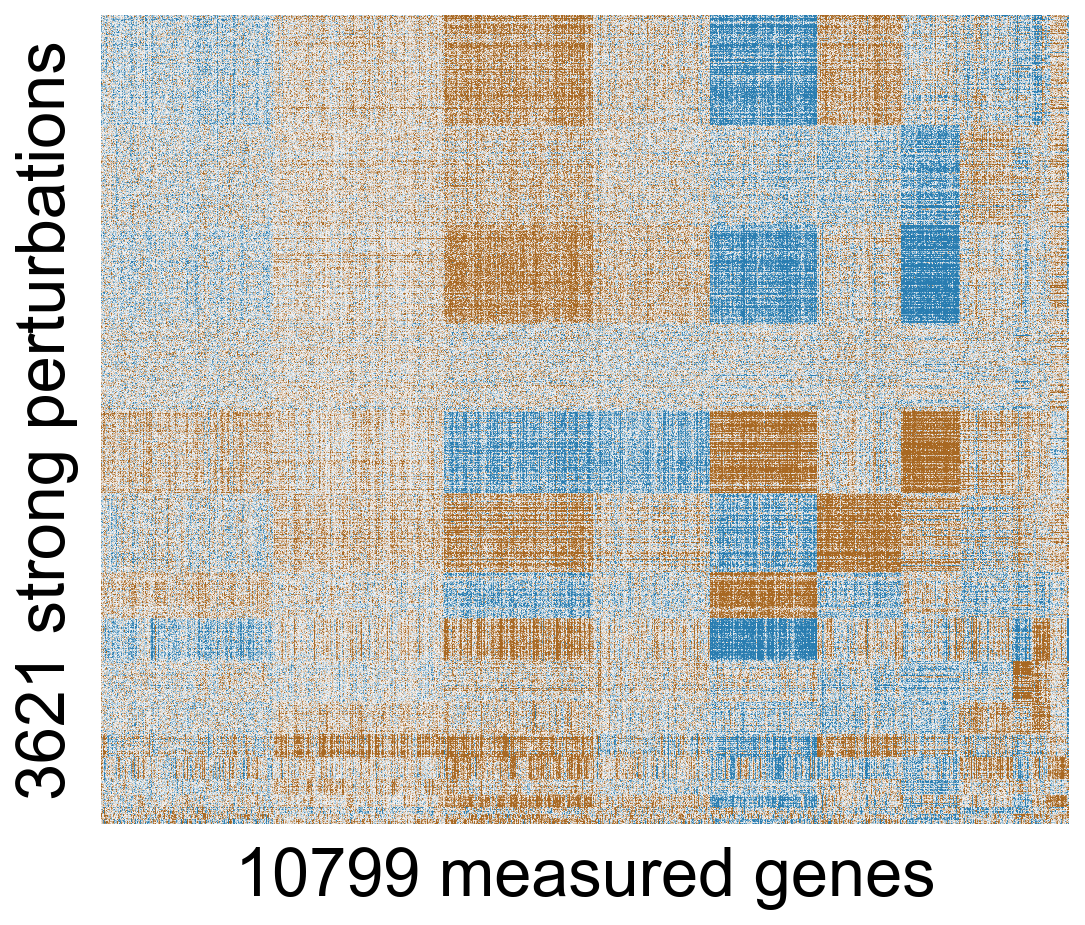

In [221]:
from scipy.ndimage import gaussian_filter
heatmap_data = gaussian_filter(adata_de_filtered[adata_de_tmp.obs.sort_values(by='leiden').index,
    adata_transposed.obs.sort_values(by='leiden').index].layers['zscore'], sigma=0.8)

plt.figure(figsize=(7, 6))
sns.heatmap(heatmap_data, cmap=custom_cmap, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, cbar=False)
plt.xlabel(str(adata_de_filtered.shape[1])+' measured genes', fontsize=30, labelpad=10)
plt.ylabel(str(adata_de_filtered.shape[0])+' strong perturbations', fontsize=30, labelpad=10)
plt.tight_layout()
plt.savefig('./results/adata_de_filter_heatmap_for_schematics.png')

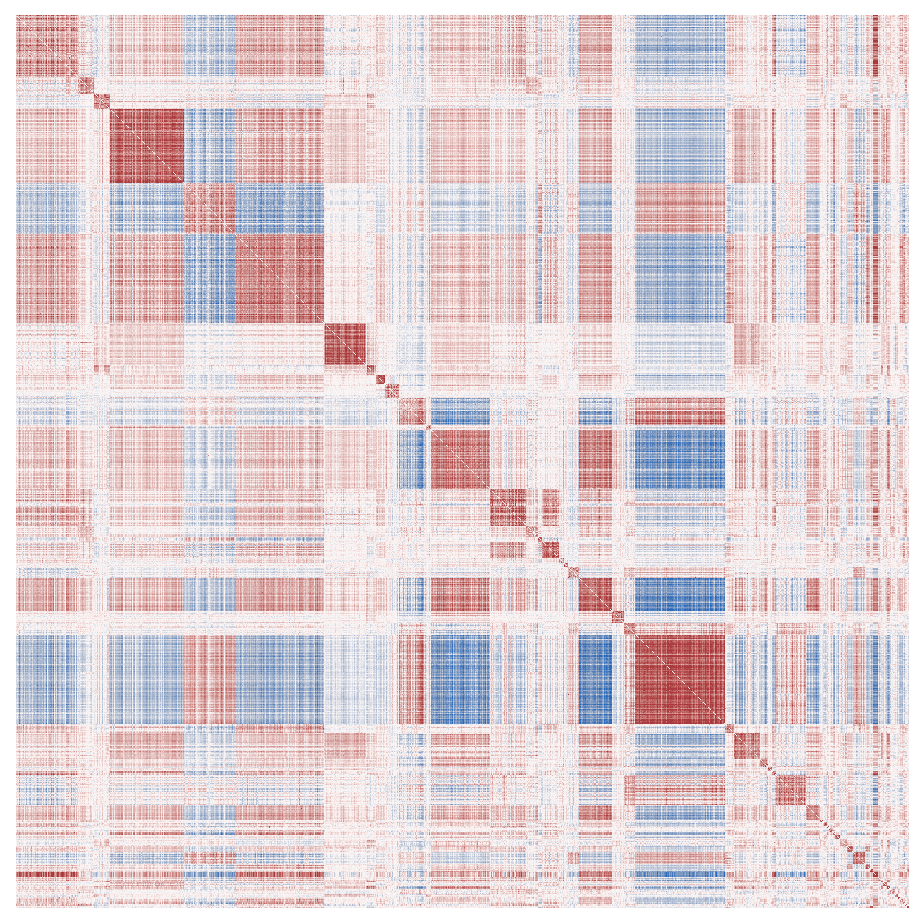

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
data = np.empty([0,adata_final.shape[1]])
ind = []
for i in adata_final.obs['hdbscan'].unique():
    data = np.concatenate([data, adata_final[adata_final.obs['hdbscan']==i].layers['zscore']])
    list1 = adata_final[adata_final.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata_final[adata_final.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]

df = pd.DataFrame(data=data, index=ind, columns=adata_final.var_names)
df_plot = df.T.corr()
np.fill_diagonal(df_plot.values, 0)
sns.heatmap(df_plot, vmin=-0.5, vmax=0.5, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax)
plt.tight_layout()
plt.savefig('./results/adata_final_cluster_heatmap_for_schematics.png')
#plt.xlabel(str(adata_final.shape[1])+' measured genes', fontsize=20)
#plt.ylabel(str(adata_final.shape[0])+' perturbations', fontsize=20)

In [6]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

In [8]:
len(cluster_list)

61

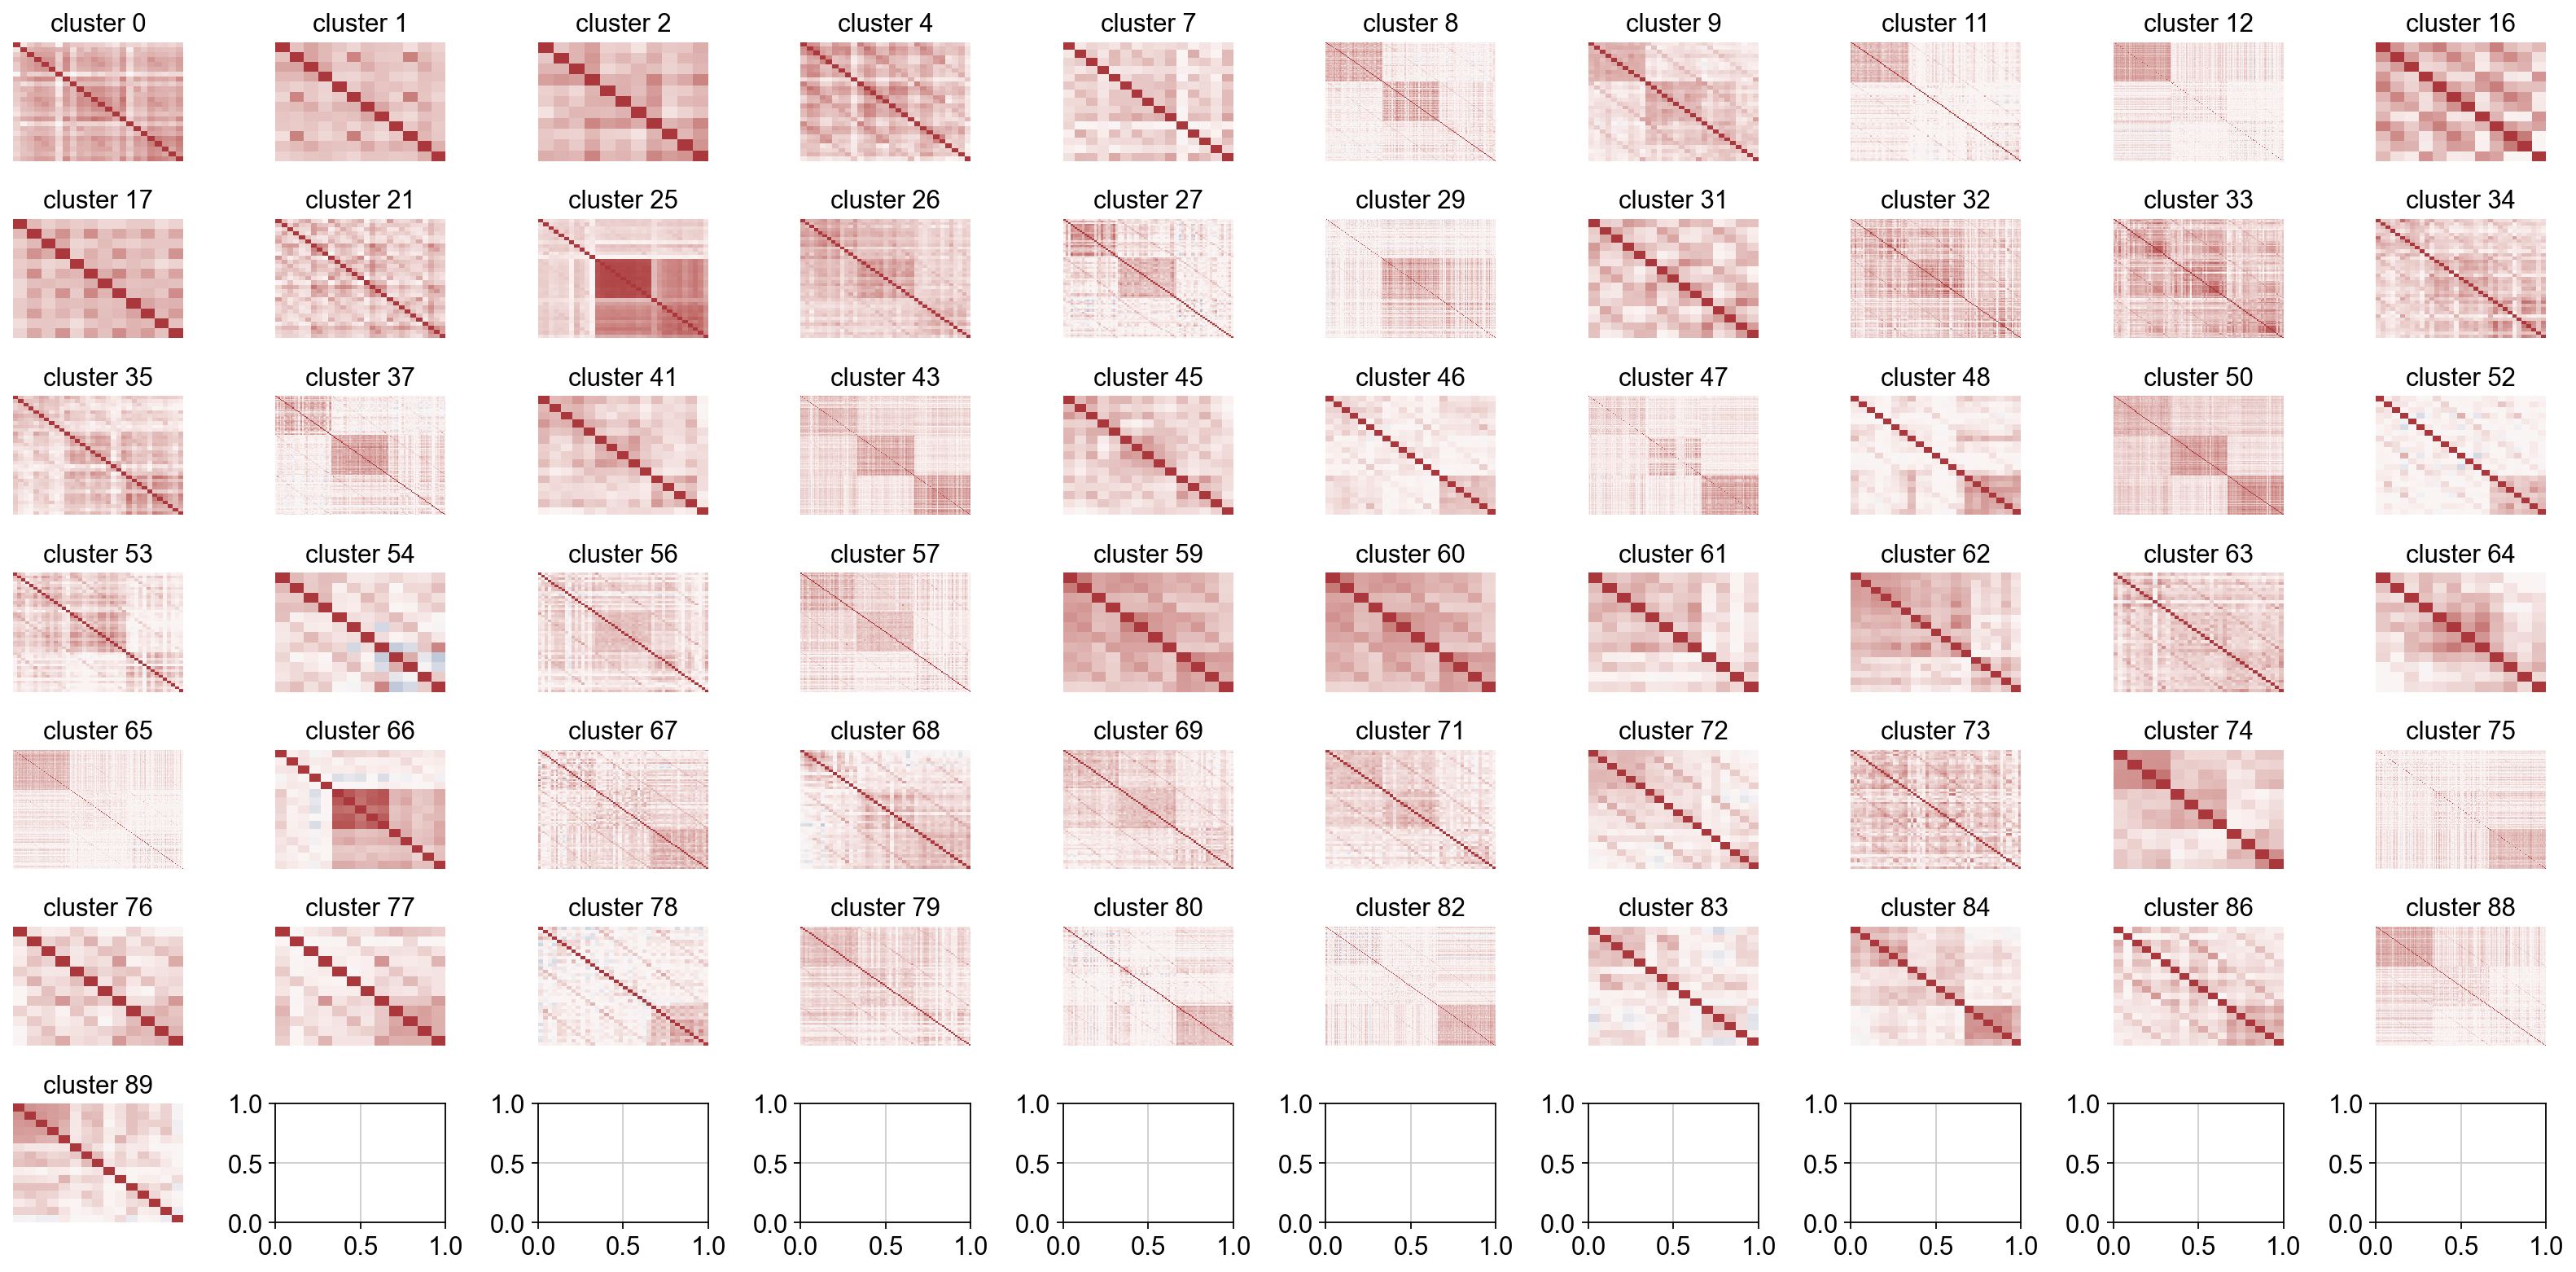

In [20]:
fig, axes = plt.subplots(7,10,figsize=(20,10))
ax = axes.flatten()
cluster_list = np.sort(adata_final.obs.hdbscan.unique())
for i in range(len(cluster_list)):
    genelist = adata_final[adata_final.obs.hdbscan==cluster_list[i]].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-1, vmax=1, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cluster_list[i]))
plt.tight_layout()

In [164]:
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

In [179]:
adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']

ENSG00000011198_Rest      ABHD5
ENSG00000038382_Rest       TRIO
ENSG00000064309_Rest       CDON
ENSG00000078747_Rest       ITCH
ENSG00000084636_Rest    COL16A1
                         ...   
ENSG00000198342_Rest     ZNF442
ENSG00000205572_Rest     SERF1B
ENSG00000221890_Rest      NPTXR
ENSG00000236320_Rest     SLFN14
ENSG00000246705_Rest       H2AJ
Name: target_contrast_gene_name_corrected, Length: 11287, dtype: category
Categories (11287, object): ['A1BG', 'A2M', 'AAAS', 'AACS', ..., 'ZXDC', 'ZYG11B', 'ZYX', 'ZZEF1']

In [189]:
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

In [166]:
corr_mtx.loc[regulator_main_condition,regulator_main_condition]

PLAT_Stim8hr  COG5_Stim8hr  ATXN7L3_Stim8hr  EML2_Stim8hr  \
PLAT_Stim8hr         1.000000      0.189972         0.217678      0.364921   
COG5_Stim8hr         0.189972      1.000000         0.137813      0.143461   
ATXN7L3_Stim8hr      0.217678      0.137813         1.000000      0.117147   
EML2_Stim8hr         0.364921      0.143461         0.117147      1.000000   
USP22_Stim8hr        0.227913      0.180576         0.590598      0.149527   
...                       ...           ...              ...           ...   
MBD5_Stim8hr         0.652010      0.265386         0.297316      0.379195   
COG6_Stim8hr         0.317617      0.424584         0.205788      0.207043   
ACO2_Stim8hr         0.322037      0.175672         0.161083      0.194653   
RREB1_Stim8hr        0.262212      0.122380         0.128433      0.123404   
C8orf82_Stim8hr      0.136925      0.160545         0.134961      0.056820   

                 USP22_Stim8hr  RAC2_Stim8hr  CAMSAP1_Stim8hr  LCK_Stim8hr  \
PLAT_Stim8hr          0.227913      0.225899         0.415862     0.669544   
COG5_Stim8hr          0.180576      0.180687         0.214940     0.216660   
ATXN7L3_Stim8hr       0.590598      0.197456         0.235535     0.292199   
EML2_Stim8hr          0.149527      0.175355         0.374755     0.377884   
USP22_Stim8hr         1.000000      0.232137         0.203911     0.264812   
...                        ...           ...              ...          ...   
MBD5_Stim8hr          0.308282      0.318786         0.505495     0.695613   
COG6_Stim8hr          0.228815      0.218843         0.348331     0.396893   
ACO2_Stim8hr          0.200004      0.162564         0.252489     0.348722   
RREB1_Stim8hr         0.123079      0.097277         0.123761     0.199288   
C8orf82_Stim8hr       0.049240      0.096136         0.170462     0.144292   

                 RAB19_Stim8hr  DCAF11_Stim8hr  ...  ORAI1_Stim8hr  \
PLAT_Stim8hr          0.384159        0.365496  ...       0.414864   
COG5_Stim8hr          0.173559        0.191191  ...       0.162227   
ATXN7L3_Stim8hr       0.230896        0.190861  ...       0.214618   
EML2_Stim8hr          0.163836        0.258814  ...       0.236380   
USP22_Stim8hr         0.201261        0.220731  ...       0.253660   
...                        ...             ...  ...            ...   
MBD5_Stim8hr          0.388435        0.412677  ...       0.452588   
COG6_Stim8hr          0.209056        0.337343  ...       0.303986   
ACO2_Stim8hr          0.223495        0.175557  ...       0.207187   
RREB1_Stim8hr         0.186134        0.136909  ...       0.153176   
C8orf82_Stim8hr       0.153897        0.122039  ...       0.057065   

                 CARMIL2_Stim8hr  THAP12_Stim8hr  MALT1_Stim8hr  \
PLAT_Stim8hr            0.575252        0.398316       0.470634   
COG5_Stim8hr            0.294265        0.207732       0.257029   
ATXN7L3_Stim8hr         0.201758        0.221487       0.262077   
EML2_Stim8hr            0.468993        0.266488       0.447381   
USP22_Stim8hr           0.262135        0.249554       0.273649   
...                          ...             ...            ...   
MBD5_Stim8hr            0.637800        0.481266       0.589138   
COG6_Stim8hr            0.401771        0.312824       0.401478   
ACO2_Stim8hr            0.324568        0.251360       0.292093   
RREB1_Stim8hr           0.231021        0.159588       0.146696   
C8orf82_Stim8hr         0.154605        0.160935       0.151993   

                 VPS29_Stim8hr  MBD5_Stim8hr  COG6_Stim8hr  ACO2_Stim8hr  \
PLAT_Stim8hr          0.297071      0.652010      0.317617      0.322037   
COG5_Stim8hr          0.101069      0.265386      0.424584      0.175672   
ATXN7L3_Stim8hr       0.056903      0.297316      0.205788      0.161083   
EML2_Stim8hr          0.168417      0.379195      0.207043      0.194653   
USP22_Stim8hr         0.104385      0.308282      0.228815      0.200004   
...                        ...           

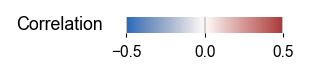

In [282]:
# Seaborn vlag colormap
cmap = sns.color_palette("vlag", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(1.4, 0.25))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=7, width=0.5, length=2)

# Add "Correlation" label on the left
ax.text(-0.15, 0.5, "Correlation", fontsize=8, va='center', ha='right', transform=ax.transAxes)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.8, bottom=0.4)

plt.show()

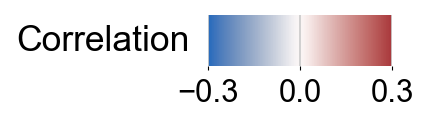

In [299]:
thres = 0.3
cmap = sns.color_palette("vlag", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(3, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=14, width=0.5, length=2)
cb.set_ticks([-thres, 0, thres])

# Add "Correlation" label on the left
ax.text(-0.1, 0.5, "Correlation", fontsize=16, va='center', ha='right', transform=ax.transAxes)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar'+str(thres)+'.png')

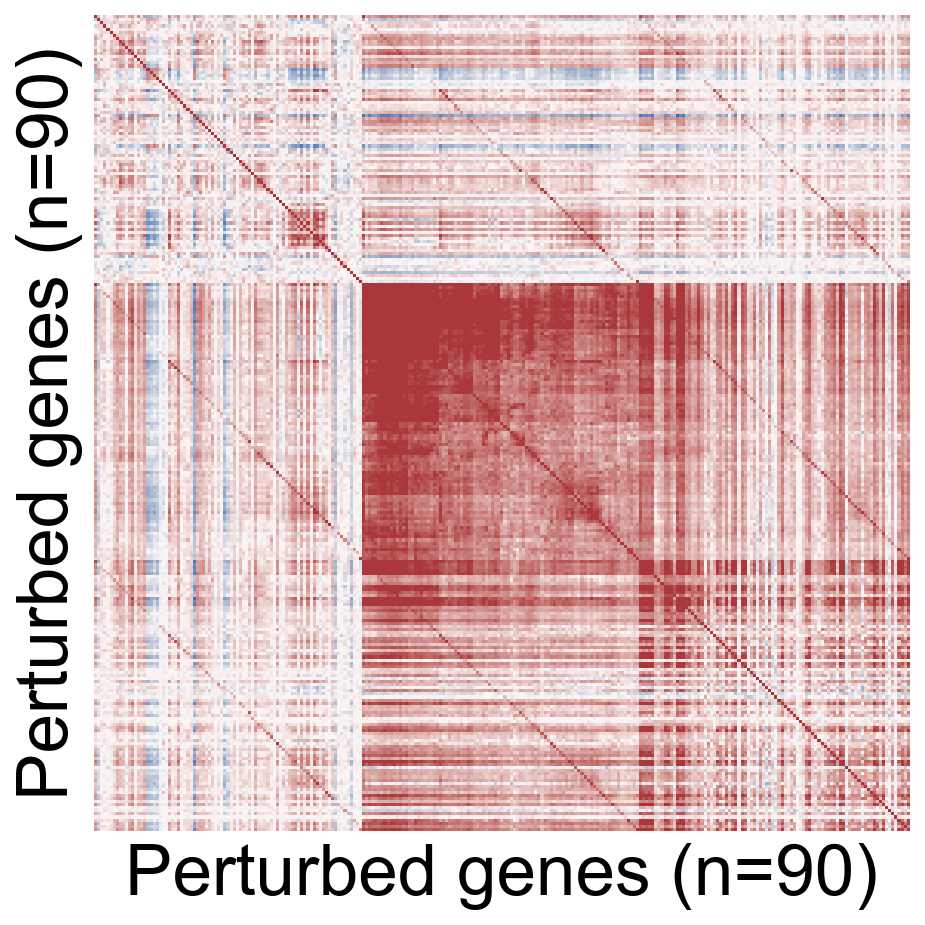

In [25]:
cl = 29
thres = 0.4
plt.figure(figsize=(6, 6))
genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)

# Reorder regulator based on hierarchical clustering of regulators in main conditions
# For each cluster, get regulator member list
regulator = adata_final[adata_final.obs['hdbscan']==cl].obs['target_contrast_gene_name_corrected'].tolist()
main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
regulator_main_condition = [item+'_'+main_condition for item in regulator]

# Get reordered downstream genes based on DE effect of main condition
clustermap = sns.clustermap(corr_mtx.loc[regulator_main_condition, regulator_main_condition], 
                            method='average', 
                            metric='euclidean')
xticklabel_indices = clustermap.dendrogram_col.reordered_ind
plt.close(clustermap.fig)
regulator_reordered = np.array(regulator)[xticklabel_indices]

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_rest)
regulator_rest = regulator_reordered[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
regulator_stim8hr = regulator_reordered[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_gene_name_corrected']
isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
regulator_stim48hr = regulator_reordered[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

sns.heatmap(corr_mtx.loc[regulator_all, regulator_all], vmin=-thres, vmax=thres, cmap='vlag', xticklabels=False, yticklabels=False, cbar=False)
plt.xlabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.ylabel('Perturbed genes (n='+str(len(genelist))+')', fontsize=32, labelpad=5)
plt.tight_layout()
plt.savefig('./results/cluster'+str(cl)+'.png')

In [75]:
de_summary_stats

target_contrast target_name condition  n_cells_target  n_up_genes  \
0      ENSG00000012963        UBR7   Stim8hr           491.0           0   
1      ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2      ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3      ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4      ENSG00000100504        PYGL   Stim8hr           414.0           1   
...                ...         ...       ...             ...         ...   
33981  ENSG00000198342      ZNF442      Rest           324.0           0   
33982  ENSG00000205572      SERF1B      Rest            44.0           7   
33983  ENSG00000221890       NPTXR      Rest           293.0           0   
33984  ENSG00000236320      SLFN14      Rest           848.0           0   
33985  ENSG00000246705       H2AFJ      Rest          1173.0           2   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
0                 2                 2            -12.952742   
1                 1                 1            -16.307246   
2                 1                 2             -1.658755   
3                 2                 2            -19.259466   
4                 0                 1              0.000000   
...             ...               ...                   ...   
33981             0                 0              0.000000   
33982            24                31              0.000000   
33983             3                 3             -1.027171   
33984             0                 0              0.000000   
33985             2                 4            -18.574962   

       ontarget_significant    baseMean  offtarget_flag  \
0                      True   43.169196            True   
1                      True  102.399025           False   
2                     False    0.965897           False   
3                      True   60.904483           False   
4                     False         NaN           False   
...                     ...         ...             ...   
33981                 False         NaN           False   
33982                 False         NaN           False   
33983                 False    0.798092           False   
33984                 False         NaN           False   
33985                  True   42.729358            True   

      n_total_genes_category ontarget_effect_category  \
0              2-10 DE genes             on-target KD   
1                  1 DE gene             on-target KD   
2              2-10 DE genes          no on-target KD   
3              2-10 DE genes             on-target KD   
4                  1 DE gene          no on-target KD   
...                      ...                      ...   
33981              no effect          no on-target KD   
33982           >10 DE genes          no on-target KD   
33983          2-10 DE genes          no on-target KD   
33984              no effect          no on-target KD   
33985          2-10 DE genes             on-target KD   

      target_contrast_corrected                obs_names target_name_corrected  
0               ENSG00000012963  ENSG00000012963_Stim8hr                  UBR7  
1               ENSG00000017260  ENSG00000017260_Stim8hr                ATP2C1  
2               ENSG00000067606  ENSG00000067606_Stim8hr                 PRKCZ  
3               ENSG00000092929  ENSG00000092929_Stim8hr                UNC13D  
4               ENSG00000100504  ENSG00000100504_Stim8hr                  PYGL  
...                         ...                      ...                   ...  
33981           ENSG00000198342     ENSG00000198342_Rest                ZNF442  
33982           ENSG00000205572     ENSG00000205572_Rest                SERF1B  
33983           ENSG00000221890     ENSG00000221890_Rest                 NPTXR  
33984           ENSG00000236320     ENSG00000236320_Rest                SLFN14  
33985           ENSG00000246705     ENSG00000246705_

In [76]:
de_summary_stats[de_summary_stats.target_name=='CD2']

target_contrast target_name condition  n_cells_target  n_up_genes  \
3210   ENSG00000116824         CD2  Stim48hr           478.0         537   
14449  ENSG00000116824         CD2      Rest           405.0           3   
33697  ENSG00000116824         CD2   Stim8hr           378.0         354   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
3210            452               989            -40.504027   
14449             1                 4            -30.141238   
33697           315               669            -50.578725   

       ontarget_significant     baseMean  offtarget_flag  \
3210                   True  1050.252098           False   
14449                  True   510.779770           False   
33697                  True  1719.681608           False   

      n_total_genes_category ontarget_effect_category  \
3210            >10 DE genes             on-target KD   
14449          2-10 DE genes             on-target KD   
33697           >10 DE genes             on-target KD   

      target_contrast_corrected                 obs_names  \
3210            ENSG00000116824  ENSG00000116824_Stim48hr   
14449           ENSG00000116824      ENSG00000116824_Rest   
33697           ENSG00000116824   ENSG00000116824_Stim8hr   

      target_name_corrected  
3210                    CD2  
14449                   CD2  
33697                   CD2

In [11]:
Tcellsignal = ['CD3D','ZAP70','LAT','FYN','ITAM','ITK','GADS','ADAP','GRB2','PLCG1','PLCG2','WAS','RAC2','CD28','DEF6','CD2']

In [128]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(Tcellsignal)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000116824_Stim48hr                       CD2          Stim48hr   
ENSG00000178562_Stim8hr                       CD28           Stim8hr   
ENSG00000178562_Stim48hr                      CD28          Stim48hr   
ENSG00000167286_Stim8hr                       CD3D           Stim8hr   
ENSG00000023892_Stim8hr                       DEF6           Stim8hr   
ENSG00000113263_Stim8hr                        ITK           Stim8hr   
ENSG00000113263_Stim48hr                       ITK          Stim48hr   
ENSG00000213658_Stim48hr                       LAT          Stim48hr   
ENSG00000213658_Stim8hr                        LAT           Stim8hr   
ENSG00000124181_Stim8hr                      PLCG1           Stim8hr   
ENSG00000124181_Stim48hr                     PLCG1          Stim48hr   
ENSG00000128340_Stim8hr                       RAC2           Stim8hr   
ENSG00000128340_Stim48hr                      RAC2          Stim48hr   
ENSG00000015285_Stim8hr                        WAS           Stim8hr   
ENSG00000115085_Stim8hr                      ZAP70           Stim8hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000116824_Stim48hr  ENSG00000116824    64           478.0   
ENSG00000178562_Stim8hr   ENSG00000178562    99           675.0   
ENSG00000178562_Stim48hr  ENSG00000178562   401           514.0   
ENSG00000167286_Stim8hr   ENSG00000167286   436           185.0   
ENSG00000023892_Stim8hr   ENSG00000023892   447           541.0   
ENSG00000113263_Stim8hr   ENSG00000113263   443           517.0   
ENSG00000113263_Stim48hr  ENSG00000113263   610           361.0   
ENSG00000213658_Stim48hr  ENSG00000213658   635           295.0   
ENSG00000213658_Stim8hr   ENSG00000213658   662           469.0   
ENSG00000124181_Stim8hr   ENSG00000124181    87           421.0   
ENSG00000124181_Stim48hr  ENSG00000124181   210           267.0   
ENSG00000128340_Stim8hr   ENSG00000128340    46           576.0   
ENSG00000128340_Stim48hr  ENSG00000128340   392           519.0   
ENSG00000015285_Stim8hr   ENSG00000015285   164           522.0   
ENSG00000115085_Stim8hr   ENSG00000115085   249           144.0   

                         target_contrast_corrected  \
ENSG00000116824_Stim48hr           ENSG00000116824   
ENSG00000178562_Stim8hr            ENSG00000178562   
ENSG00000178562_Stim48hr           ENSG00000178562   
ENSG00000167286_Stim8hr            ENSG00000167286   
ENSG00000023892_Stim8hr            ENSG00000023892   
ENSG00000113263_Stim8hr            ENSG00000113263   
ENSG00000113263_Stim48hr           ENSG00000113263   
ENSG00000213658_Stim48hr           ENSG00000213658   
ENSG00000213658_Stim8hr            ENSG00000213658   
ENSG00000124181_Stim8hr            ENSG00000124181   
ENSG00000124181_Stim48hr           ENSG00000124181   
ENSG00000128340_Stim8hr            ENSG00000128340   
ENSG00000128340_Stim48hr           ENSG00000128340   
ENSG00000015285_Stim8hr            ENSG00000015285   
ENSG00000115085_Stim8hr            ENSG00000115085   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000116824_Stim48hr                                 CD2     101  
ENSG00000178562_Stim8hr                                 CD28      36  
ENSG00000178562_Stim48hr                                CD28     101  
ENSG00000167286_Stim8hr                                 CD3D      29  
ENSG00000023892_Stim8hr                                 DEF6      36  
ENSG00000113263_Stim8hr                                  ITK      36  
ENSG00000113263_Stim48hr                                 ITK     101  
ENSG00000213658_Stim48hr                                 LAT     101  
ENSG00000213658_Stim8hr                                  LAT      29  
ENSG00000124181_Stim8hr                                PLCG1      29  
ENSG00000124181_Stim48hr                               PLCG1     101  
ENSG00000128340_Stim8hr                                 RAC2      36  
ENSG0000012

In [338]:
de_summary_stats[de_summary_stats.target_name.isin(genelist)]

target_contrast target_name condition  n_cells_target  n_up_genes  \
433    ENSG00000163931         TKT  Stim48hr           172.0           0   
3967   ENSG00000130313        PGLS      Rest           111.0           3   
4583   ENSG00000160211        G6PD   Stim8hr           454.0           1   
6231   ENSG00000197713         RPE   Stim8hr           336.0          87   
10412  ENSG00000142657         PGD   Stim8hr            35.0          74   
10565  ENSG00000153574        RPIA      Rest            89.0           4   
13665  ENSG00000163931         TKT   Stim8hr           144.0           1   
14267  ENSG00000163931         TKT      Rest           105.0           3   
16413  ENSG00000160211        G6PD      Rest           395.0           1   
17329  ENSG00000177156      TALDO1  Stim48hr           690.0           0   
19417  ENSG00000160211        G6PD  Stim48hr           412.0           6   
21911  ENSG00000153574        RPIA  Stim48hr            81.0           2   
22906  ENSG00000130313        PGLS   Stim8hr            57.0          21   
22917  ENSG00000153574        RPIA   Stim8hr           151.0           8   
23334  ENSG00000197713         RPE      Rest           434.0           6   
24782  ENSG00000197713         RPE  Stim48hr           249.0         215   
27275  ENSG00000177156      TALDO1      Rest           667.0           0   
27880  ENSG00000177156      TALDO1   Stim8hr           661.0           0   
29244  ENSG00000130313        PGLS  Stim48hr            36.0         133   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
433               0                 0              0.000000   
3967              1                 4             -5.397647   
4583              1                 2            -13.000797   
6231             30               117             -8.965289   
10412            18                92             -3.768551   
10565             1                 5             -5.154019   
13665             0                 1              0.000000   
14267             1                 4              0.000000   
16413             1                 2            -10.519646   
17329             1                 1            -17.607958   
19417             1                 7            -14.415688   
21911             1                 3             -7.419682   
22906             2                23             -3.930633   
22917             1                 9            -15.182825   
23334             3                 9             -8.394173   
24782           111               326             -7.441241   
27275             1                 1            -14.507239   
27880             1                 1            -12.011494   
29244            26               159             -2.158867   

       ontarget_significant    baseMean  offtarget_flag  \
433                   False         NaN           False   
3967                   True   37.278649           False   
4583                   True   70.268081           False   
6231                   True   30.015471           False   
10412                  True   55.955169           False   
10565                  True   51.096110           False   
13665                 False         NaN           False   
14267                 False         NaN           False   
16413                  True   69.224318           False   
17329                  True  123.148268           False   
19417                  True  101.174846           False   
21911                  True   95.376372           False   
22906                  True   32.400053           False   
22917                  True  227.728358           False   
23334                  True   17.372956           False   
24782                  True   32.532421           False   
27275                  True   88.477314           False   
27880                  True   71.711408           False   
29244                 False   34.015424           False   

      n_total_genes_category ontarget_effect

In [336]:
genelist = ['G6PD', 'PGLS', 'PGD', 'RPIA', 'RPE', 'TKT', 'TALDO1']

In [337]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(genelist)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000197713_Stim48hr                       RPE          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000197713_Stim48hr  ENSG00000197713   495           249.0   

                         target_contrast_corrected  \
ENSG00000197713_Stim48hr           ENSG00000197713   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000197713_Stim48hr                                 RPE     101

In [321]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.str.startswith('CPT')].obs.sort_values(by='target_contrast_gene_name_corrected')

Empty DataFrame
Columns: [target_contrast_gene_name, culture_condition, target_contrast, chunk, n_cells_target, target_contrast_corrected, target_contrast_gene_name_corrected, hdbscan]
Index: []

In [306]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(['FOXO1','AMPK'])].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000150907_Stim8hr                      FOXO1           Stim8hr   
ENSG00000150907_Stim48hr                     FOXO1          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000150907_Stim8hr   ENSG00000150907   339           723.0   
ENSG00000150907_Stim48hr  ENSG00000150907   489           901.0   

                         target_contrast_corrected  \
ENSG00000150907_Stim8hr            ENSG00000150907   
ENSG00000150907_Stim48hr           ENSG00000150907   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000150907_Stim8hr                                FOXO1      27  
ENSG00000150907_Stim48hr                               FOXO1     101

In [344]:
adata_final[adata_final.obs.hdbscan==98].obs['target_contrast_gene_name_corrected'].tolist()

['THAP12', 'CTSO', 'HRAS', 'USP24', 'CHTF18']

In [342]:
adata_final[adata_final.obs.hdbscan==98].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000127586_Stim48hr                    CHTF18          Stim48hr   
ENSG00000256043_Stim48hr                      CTSO          Stim48hr   
ENSG00000174775_Stim48hr                      HRAS          Stim48hr   
ENSG00000137492_Stim48hr                    THAP12          Stim48hr   
ENSG00000162402_Stim48hr                     USP24          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000127586_Stim48hr  ENSG00000127586   635           200.0   
ENSG00000256043_Stim48hr  ENSG00000256043   412          1140.0   
ENSG00000174775_Stim48hr  ENSG00000174775   482           473.0   
ENSG00000137492_Stim48hr  ENSG00000137492    50           913.0   
ENSG00000162402_Stim48hr  ENSG00000162402   607           519.0   

                         target_contrast_corrected  \
ENSG00000127586_Stim48hr           ENSG00000127586   
ENSG00000256043_Stim48hr           ENSG00000256043   
ENSG00000174775_Stim48hr           ENSG00000174775   
ENSG00000137492_Stim48hr           ENSG00000137492   
ENSG00000162402_Stim48hr           ENSG00000162402   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000127586_Stim48hr                              CHTF18      98  
ENSG00000256043_Stim48hr                                CTSO      98  
ENSG00000174775_Stim48hr                                HRAS      98  
ENSG00000137492_Stim48hr                              THAP12      98  
ENSG00000162402_Stim48hr                               USP24      98

In [6]:
norm_cooc_matrix_df = pd.read_csv('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24_cooc_matrix.csv', index_col=0)
distance_matrix = 1 - norm_cooc_matrix_df.values
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix_df.values)

In [60]:
distance_matrix_adata = anndata.AnnData(1 - norm_cooc_matrix_df)

In [63]:
sc.pp.neighbors(distance_matrix_adata, n_neighbors=7, use_rep='X')
sc.tl.leiden(distance_matrix_adata, resolution=2)
adata.obs['leiden'] = norm_cooc_matrix_adata.obs['leiden'].astype(int)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


In [50]:
adata.obs['leiden'] = norm_cooc_matrix_adata.obs['leiden'].astype(int)
adata.obs_names = [item1+'_'+item2 for item1, item2 in zip(adata.obs['target_contrast_gene_name_corrected'], adata.obs['culture_condition'])]

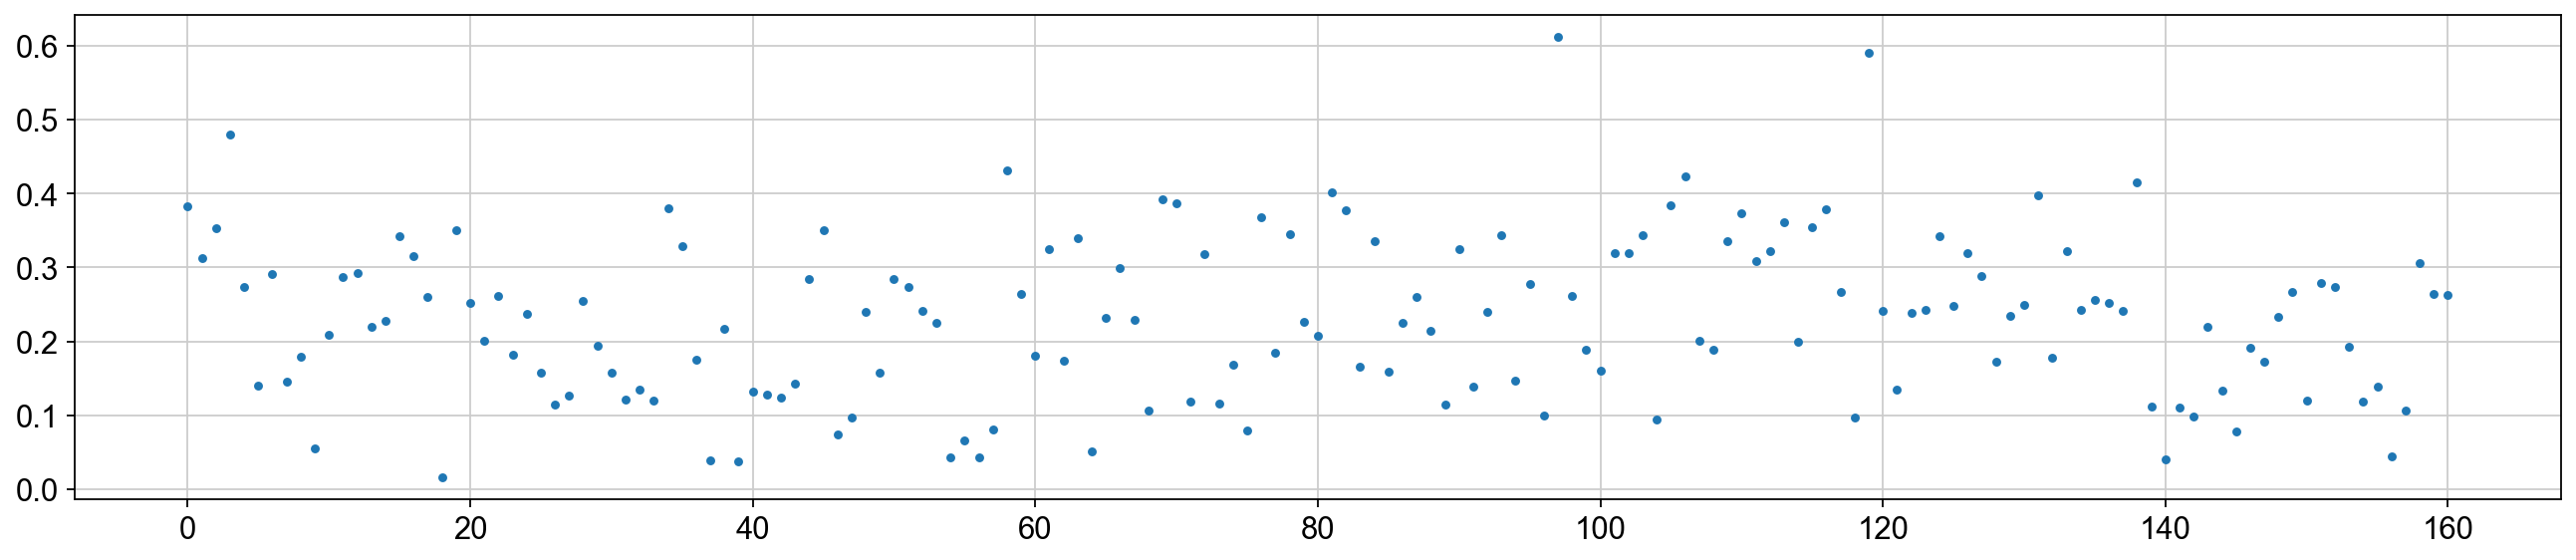

In [64]:
num_of_cluster = np.max(adata.obs['leiden'].astype(int))+1
corr = np.zeros(num_of_cluster)
cluster_size = np.zeros(num_of_cluster)
cluster_gene_size = np.zeros(num_of_cluster)
cluster_member = []
for i in range(len(corr)):
    test = pd.DataFrame(data=adata[adata.obs['leiden']==i].layers['zscore'],
                        index=adata[adata.obs['leiden']==i].obs_names,
                        columns=adata.var_names)
    test2 = test.T.corr()
    np.fill_diagonal(test2.values, 0)
    corr[i] = np.mean(test2)
    cluster_size[i] = len(test)
    cluster_gene_size[i] = len(adata[adata.obs['leiden']==i].obs.target_contrast_gene_name_corrected.unique())
    cluster_member.append(adata[adata.obs['leiden']==i].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': np.arange(0, num_of_cluster, 1),
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

plt.plot(cluster_df.intracluster_corr, '.')

In [78]:
distance_matrix

array([[0.16666667, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.13333333, 0.99987654, ..., 1.        , 1.        ,
        0.99962963],
       [1.        , 0.99987654, 0.12333333, ..., 1.        , 1.        ,
        0.79074074],
       ...,
       [1.        , 1.        , 1.        , ..., 0.16      , 0.79925926,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.79925926, 0.16666667,
        1.        ],
       [1.        , 0.99962963, 0.79074074, ..., 1.        , 1.        ,
        0.13333333]])

In [4]:
adata_cluster = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

In [7]:
distance_matrix

array([[0.16666667, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.13333333, 0.99987654, ..., 1.        , 1.        ,
        0.99962963],
       [1.        , 0.99987654, 0.12333333, ..., 1.        , 1.        ,
        0.79074074],
       ...,
       [1.        , 1.        , 1.        , ..., 0.16      , 0.79925926,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.79925926, 0.16666667,
        1.        ],
       [1.        , 0.99962963, 0.79074074, ..., 1.        , 1.        ,
        0.13333333]])

In [27]:
sc.tl.leiden(adata, resolution=1.5)
adata.obs['leiden'] = adata.obs['leiden'].astype(int)

In [10]:
adata

AnnData object with n_obs × n_vars = 3621 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'leiden'
    var: 'gene_ids', 'gene_name'
    uns: 'neighbors', 'leiden'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'
    obsp: 'connectivities', 'distances'

In [346]:
k = 5
transformed_matrix = (np.tanh(k * (distance_matrix - 0.5)) / np.tanh(k)) * 0.5 + 0.5

In [252]:
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=6,
                            min_samples=5,
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix)
#clusterer.fit(transformed_matrix)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')

In [355]:
distance_matrix.shape

(3621, 3621)

In [51]:
adata[adata.obs.target_contrast_gene_name_corrected.isin(Tcellsignal)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
CD2_Stim8hr                          CD2           Stim8hr  ENSG00000116824   
CD2_Stim48hr                         CD2          Stim48hr  ENSG00000116824   
CD28_Stim8hr                        CD28           Stim8hr  ENSG00000178562   
CD28_Stim48hr                       CD28          Stim48hr  ENSG00000178562   
CD3D_Stim8hr                        CD3D           Stim8hr  ENSG00000167286   
DEF6_Stim8hr                        DEF6           Stim8hr  ENSG00000023892   
ITK_Stim48hr                         ITK          Stim48hr  ENSG00000113263   
ITK_Stim8hr                          ITK           Stim8hr  ENSG00000113263   
LAT_Stim48hr                         LAT          Stim48hr  ENSG00000213658   
LAT_Stim8hr                          LAT           Stim8hr  ENSG00000213658   
PLCG1_Stim8hr                      PLCG1           Stim8hr  ENSG00000124181   
PLCG1_Stim48hr                     PLCG1          Stim48hr  ENSG00000124181   
RAC2_Stim8hr                        RAC2           Stim8hr  ENSG00000128340   
RAC2_Stim48hr                       RAC2          Stim48hr  ENSG00000128340   
WAS_Stim8hr                          WAS           Stim8hr  ENSG00000015285   
ZAP70_Stim8hr                      ZAP70           Stim8hr  ENSG00000115085   
ZAP70_Rest                         ZAP70              Rest  ENSG00000115085   

               chunk  n_cells_target target_contrast_corrected  \
CD2_Stim8hr      675           378.0           ENSG00000116824   
CD2_Stim48hr      64           478.0           ENSG00000116824   
CD28_Stim8hr      99           675.0           ENSG00000178562   
CD28_Stim48hr    401           514.0           ENSG00000178562   
CD3D_Stim8hr     436           185.0           ENSG00000167286   
DEF6_Stim8hr     447           541.0           ENSG00000023892   
ITK_Stim48hr     610           361.0           ENSG00000113263   
ITK_Stim8hr      443           517.0           ENSG00000113263   
LAT_Stim48hr     635           295.0           ENSG00000213658   
LAT_Stim8hr      662           469.0           ENSG00000213658   
PLCG1_Stim8hr     87           421.0           ENSG00000124181   
PLCG1_Stim48hr   210           267.0           ENSG00000124181   
RAC2_Stim8hr      46           576.0           ENSG00000128340   
RAC2_Stim48hr    392           519.0           ENSG00000128340   
WAS_Stim8hr      164           522.0           ENSG00000015285   
ZAP70_Stim8hr    249           144.0           ENSG00000115085   
ZAP70_Rest       397           141.0           ENSG00000115085   

               target_contrast_gene_name_corrected  leiden  
CD2_Stim8hr                                    CD2      31  
CD2_Stim48hr                                   CD2      66  
CD28_Stim8hr                                  CD28      20  
CD28_Stim48hr                                 CD28      34  
CD3D_Stim8hr                                  CD3D      24  
DEF6_Stim8hr                                  DEF6      22  
ITK_Stim48hr                                   ITK     119  
ITK_Stim8hr                                    ITK      97  
LAT_Stim48hr                                   LAT     119  
LAT_Stim8hr                                    LAT      24  
PLCG1_Stim8hr                                PLCG1      24  
PLCG1_Stim48hr                               PLCG1     119  
RAC2_Stim8hr                                  RAC2      22  
RAC2_Stim48hr                                 RAC2      34  
WAS_Stim8hr                                    WAS      20  
ZAP70_Stim8hr                                ZAP70      24  
ZAP70_Rest                                   ZAP70      91

In [186]:
adata[adata.obs['target_contrast_gene_name_corrected']=='COG6'].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
COG6_Rest                          COG6              Rest  ENSG00000133103   
COG6_Stim8hr                       COG6           Stim8hr  ENSG00000133103   
COG6_Stim48hr                      COG6          Stim48hr  ENSG00000133103   

              chunk  n_cells_target target_contrast_corrected  \
COG6_Rest       236           161.0           ENSG00000133103   
COG6_Stim8hr    657           159.0           ENSG00000133103   
COG6_Stim48hr   663           110.0           ENSG00000133103   

              target_contrast_gene_name_corrected hdbscan  
COG6_Rest                                    COG6      27  
COG6_Stim8hr                                 COG6      46  
COG6_Stim48hr                                COG6      93

In [ ]:
adata[adata.obs.leiden==12].obs.sort_values(by='target_contrast_gene_name_corrected')

In [102]:
adata[adata.obs.target_contrast_gene_name_corrected.isin(Tcellsignal)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000116824_Stim8hr                        CD2           Stim8hr   
ENSG00000116824_Stim48hr                       CD2          Stim48hr   
ENSG00000178562_Stim8hr                       CD28           Stim8hr   
ENSG00000178562_Stim48hr                      CD28          Stim48hr   
ENSG00000167286_Stim8hr                       CD3D           Stim8hr   
ENSG00000023892_Stim8hr                       DEF6           Stim8hr   
ENSG00000113263_Stim48hr                       ITK          Stim48hr   
ENSG00000113263_Stim8hr                        ITK           Stim8hr   
ENSG00000213658_Stim48hr                       LAT          Stim48hr   
ENSG00000213658_Stim8hr                        LAT           Stim8hr   
ENSG00000124181_Stim8hr                      PLCG1           Stim8hr   
ENSG00000124181_Stim48hr                     PLCG1          Stim48hr   
ENSG00000128340_Stim8hr                       RAC2           Stim8hr   
ENSG00000128340_Stim48hr                      RAC2          Stim48hr   
ENSG00000015285_Stim8hr                        WAS           Stim8hr   
ENSG00000115085_Stim8hr                      ZAP70           Stim8hr   
ENSG00000115085_Rest                         ZAP70              Rest   

                          target_contrast chunk  n_cells_target  \
ENSG00000116824_Stim8hr   ENSG00000116824   675           378.0   
ENSG00000116824_Stim48hr  ENSG00000116824    64           478.0   
ENSG00000178562_Stim8hr   ENSG00000178562    99           675.0   
ENSG00000178562_Stim48hr  ENSG00000178562   401           514.0   
ENSG00000167286_Stim8hr   ENSG00000167286   436           185.0   
ENSG00000023892_Stim8hr   ENSG00000023892   447           541.0   
ENSG00000113263_Stim48hr  ENSG00000113263   610           361.0   
ENSG00000113263_Stim8hr   ENSG00000113263   443           517.0   
ENSG00000213658_Stim48hr  ENSG00000213658   635           295.0   
ENSG00000213658_Stim8hr   ENSG00000213658   662           469.0   
ENSG00000124181_Stim8hr   ENSG00000124181    87           421.0   
ENSG00000124181_Stim48hr  ENSG00000124181   210           267.0   
ENSG00000128340_Stim8hr   ENSG00000128340    46           576.0   
ENSG00000128340_Stim48hr  ENSG00000128340   392           519.0   
ENSG00000015285_Stim8hr   ENSG00000015285   164           522.0   
ENSG00000115085_Stim8hr   ENSG00000115085   249           144.0   
ENSG00000115085_Rest      ENSG00000115085   397           141.0   

                         target_contrast_corrected  \
ENSG00000116824_Stim8hr            ENSG00000116824   
ENSG00000116824_Stim48hr           ENSG00000116824   
ENSG00000178562_Stim8hr            ENSG00000178562   
ENSG00000178562_Stim48hr           ENSG00000178562   
ENSG00000167286_Stim8hr            ENSG00000167286   
ENSG00000023892_Stim8hr            ENSG00000023892   
ENSG00000113263_Stim48hr           ENSG00000113263   
ENSG00000113263_Stim8hr            ENSG00000113263   
ENSG00000213658_Stim48hr           ENSG00000213658   
ENSG00000213658_Stim8hr            ENSG00000213658   
ENSG00000124181_Stim8hr            ENSG00000124181   
ENSG00000124181_Stim48hr           ENSG00000124181   
ENSG00000128340_Stim8hr            ENSG00000128340   
ENSG00000128340_Stim48hr           ENSG00000128340   
ENSG00000015285_Stim8hr            ENSG00000015285   
ENSG00000115085_Stim8hr            ENSG00000115085   
ENSG00000115085_Rest               ENSG00000115085   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000116824_Stim8hr                                  CD2      -1  
ENSG00000116824_Stim48hr                                 CD2     121  
ENSG00000178562_Stim8hr                                 CD28      -1  
ENSG00000178562_Stim48hr                                CD28     122  
ENSG00000167286_Stim8hr                                 CD3D      29  
ENSG00000023892_Stim8hr                                 DEF6      -1  
ENSG00000113263_Stim48hr                           

In [103]:
adata[adata.obs.hdbscan==122].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000170540_Stim48hr                   ARL6IP1          Stim48hr   
ENSG00000142867_Stim48hr                     BCL10          Stim48hr   
ENSG00000127152_Stim48hr                    BCL11B          Stim48hr   
ENSG00000100147_Stim48hr                   CCDC134          Stim48hr   
ENSG00000178562_Stim48hr                      CD28          Stim48hr   
ENSG00000133103_Stim48hr                      COG6          Stim48hr   
ENSG00000119599_Stim48hr                     DCAF4          Stim48hr   
ENSG00000139990_Stim48hr                     DCAF5          Stim48hr   
ENSG00000167130_Stim48hr                    DOLPP1          Stim48hr   
ENSG00000173812_Stim48hr                      EIF1          Stim48hr   
ENSG00000115459_Stim48hr                    ELMOD3          Stim48hr   
ENSG00000125746_Stim48hr                      EML2          Stim48hr   
ENSG00000102081_Stim48hr                      FMR1          Stim48hr   
ENSG00000125430_Stim48hr                  HS3ST3B1          Stim48hr   
ENSG00000104365_Stim48hr                     IKBKB          Stim48hr   
ENSG00000137265_Stim48hr                      MUM1          Stim48hr   
ENSG00000118193_Stim48hr                     KIF14          Stim48hr   
ENSG00000172175_Stim48hr                     MALT1          Stim48hr   
ENSG00000119508_Stim48hr                     NR4A3          Stim48hr   
ENSG00000228474_Stim48hr                      OST4          Stim48hr   
ENSG00000139197_Stim48hr                      PEX5          Stim48hr   
ENSG00000083535_Stim48hr                     PIBF1          Stim48hr   
ENSG00000221823_Stim48hr                    PPP3R1          Stim48hr   
ENSG00000081237_Stim48hr                     PTPRC          Stim48hr   
ENSG00000160584_Stim48hr                      SIK3          Stim48hr   
ENSG00000180008_Stim48hr                     SOCS4          Stim48hr   
ENSG00000167720_Stim48hr                       SRR          Stim48hr   
ENSG00000122145_Stim48hr                     TBX22          Stim48hr   
ENSG00000164329_Stim48hr                     TENT2          Stim48hr   
ENSG00000151135_Stim48hr                   TMEM263          Stim48hr   
ENSG00000158109_Stim48hr                    TPRG1L          Stim48hr   
ENSG00000126746_Stim48hr                    ZNF384          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000170540_Stim48hr  ENSG00000170540   179           434.0   
ENSG00000142867_Stim48hr  ENSG00000142867   512           427.0   
ENSG00000127152_Stim48hr  ENSG00000127152   679           203.0   
ENSG00000100147_Stim48hr  ENSG00000100147   462           632.0   
ENSG00000178562_Stim48hr  ENSG00000178562   401           514.0   
ENSG00000133103_Stim48hr  ENSG00000133103   663           110.0   
ENSG00000119599_Stim48hr  ENSG00000119599   341           931.0   
ENSG00000139990_Stim48hr  ENSG00000139990   255           778.0   
ENSG00000167130_Stim48hr  ENSG00000167130   506          1710.0   
ENSG00000173812_Stim48hr  ENSG00000173812    92           336.0   
ENSG00000115459_Stim48hr  ENSG00000115459   171           229.0   
ENSG00000125746_Stim48hr  ENSG00000125746   375           412.0   
ENSG00000102081_Stim48hr  ENSG00000102081   438           135.0   
ENSG00000125430_Stim48hr  ENSG00000125430   491           704.0   
ENSG00000104365_Stim48hr  ENSG00000104365   181           724.0   
ENSG00000137265_Stim48hr  ENSG00000137265   378           758.0   
ENSG00000118193_Stim48hr  ENSG00000118193   476           275.0   
ENSG00000172175_Stim48hr  ENSG00000172175   457           325.0   
ENSG00000119508_Stim48hr  ENSG00000119508   156           216.0   
ENSG00000228474_Stim48hr  ENSG00000228474    55          1168.0   
ENSG00000139197_Stim48hr  ENSG00000139197    48           745.0   
ENSG00000083535_Stim48hr  ENSG00000083535   450           301.0   
ENSG00000221823_Stim48hr  ENSG00000221823   449           811.0   
ENSG00000081237_Stim48hr  ENSG0000008123

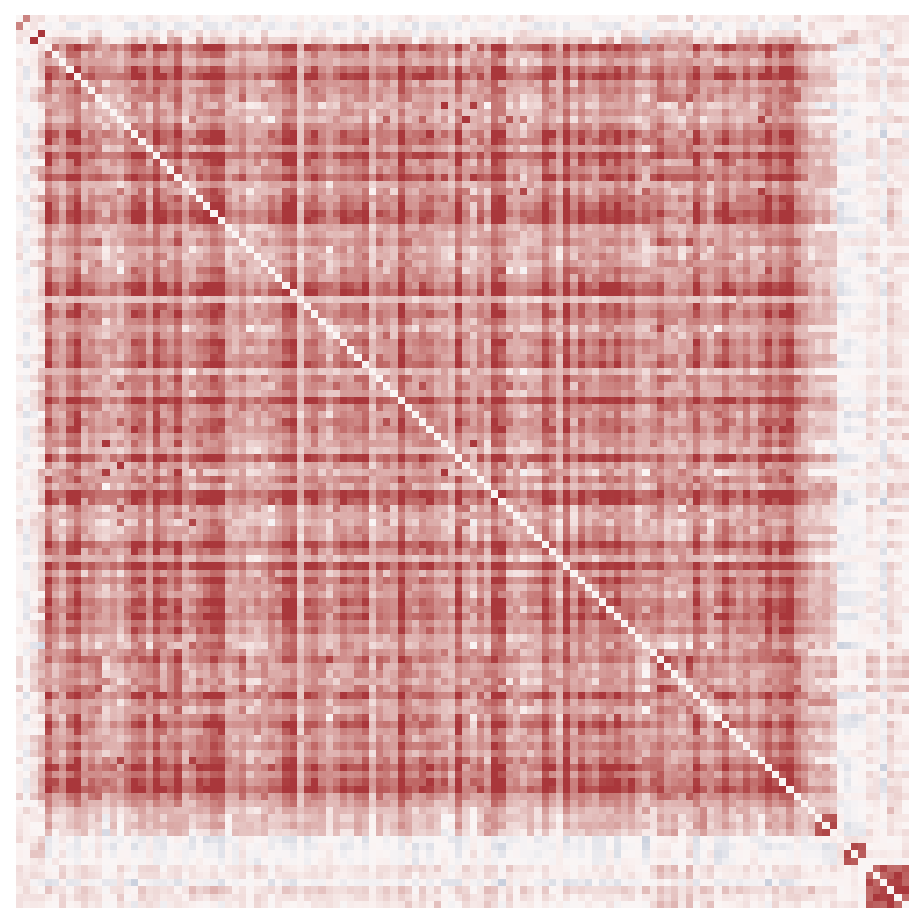

In [141]:
fig, ax = plt.subplots(figsize=(6,6))
data = np.empty([0,adata_cluster.shape[1]])
ind = []
for i in range(114,120):
    data = np.concatenate([data, adata_cluster[adata_cluster.obs['hdbscan']==i].layers['zscore']])
    list1 = adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata_cluster[adata_cluster.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]

df = pd.DataFrame(data=data, index=ind, columns=adata_final.var_names)
df_plot = df.T.corr()
np.fill_diagonal(df_plot.values, 0)
sns.heatmap(df_plot, vmin=-0.5, vmax=0.5, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax)
plt.tight_layout()

In [140]:
cluster_df[cluster_df.cluster==116]

cluster  intracluster_corr  cluster_size  cluster_gene_size  \
116      116           0.282084         107.0              107.0   

                                        cluster_member  
116  [PLAT, EML2, RAC2, CAMSAP1, LCK, RAB19, DCAF11...

In [16]:
adata

AnnData object with n_obs × n_vars = 3621 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'leiden'
    var: 'gene_ids', 'gene_name'
    uns: 'neighbors', 'leiden'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'
    obsp: 'connectivities', 'distances'

In [156]:
dist_min[dist_min<0.3].index

Index(['PLAT_Stim8hr', 'HSPA8_Stim8hr', 'KLHDC10_Stim8hr', 'ICOS_Stim8hr',
       'ANKRD49_Stim8hr', 'CTU2_Stim8hr', 'TFAM_Stim48hr', 'TMEM131L_Stim48hr',
       'SCO1_Stim48hr', 'TIMM10_Stim48hr',
       ...
       'INSR_Stim8hr', 'VWF_Stim48hr', 'RRAGC_Stim48hr', 'ARL1_Stim48hr',
       'BCL11B_Stim48hr', 'SMARCE1_Rest', 'MYCN_Rest', 'IRF4_Rest',
       'AASDH_Rest', 'TM2D1_Rest'],
      dtype='object', length=3621)

In [154]:
adata.obs

target_contrast_gene_name culture_condition  \
ENSG00000104368_Stim8hr                      PLAT           Stim8hr   
ENSG00000109971_Stim8hr                     HSPA8           Stim8hr   
ENSG00000128607_Stim8hr                   KLHDC10           Stim8hr   
ENSG00000163600_Stim8hr                      ICOS           Stim8hr   
ENSG00000168876_Stim8hr                   ANKRD49           Stim8hr   
...                                           ...               ...   
ENSG00000073584_Rest                      SMARCE1              Rest   
ENSG00000134323_Rest                         MYCN              Rest   
ENSG00000137265_Rest                         MUM1              Rest   
ENSG00000157426_Rest                        AASDH              Rest   
ENSG00000162604_Rest                        TM2D1              Rest   

                         target_contrast chunk  n_cells_target  \
ENSG00000104368_Stim8hr  ENSG00000104368     0           411.0   
ENSG00000109971_Stim8hr  ENSG00000109971     0           210.0   
ENSG00000128607_Stim8hr  ENSG00000128607     0          1257.0   
ENSG00000163600_Stim8hr  ENSG00000163600     0           658.0   
ENSG00000168876_Stim8hr  ENSG00000168876     0           228.0   
...                                  ...   ...             ...   
ENSG00000073584_Rest     ENSG00000073584   680           149.0   
ENSG00000134323_Rest     ENSG00000134323   680           924.0   
ENSG00000137265_Rest     ENSG00000137265   680           803.0   
ENSG00000157426_Rest     ENSG00000157426   680           651.0   
ENSG00000162604_Rest     ENSG00000162604   680           717.0   

                        target_contrast_corrected  \
ENSG00000104368_Stim8hr           ENSG00000104368   
ENSG00000109971_Stim8hr           ENSG00000109971   
ENSG00000128607_Stim8hr           ENSG00000128607   
ENSG00000163600_Stim8hr           ENSG00000163600   
ENSG00000168876_Stim8hr           ENSG00000168876   
...                                           ...   
ENSG00000073584_Rest              ENSG00000073584   
ENSG00000134323_Rest              ENSG00000134323   
ENSG00000137265_Rest              ENSG00000137265   
ENSG00000157426_Rest              ENSG00000157426   
ENSG00000162604_Rest              ENSG00000162604   

                        target_contrast_gene_name_corrected hdbscan  
ENSG00000104368_Stim8hr                                PLAT      -1  
ENSG00000109971_Stim8hr                               HSPA8      97  
ENSG00000128607_Stim8hr                             KLHDC10      62  
ENSG00000163600_Stim8hr                                ICOS      62  
ENSG00000168876_Stim8hr                             ANKRD49      -1  
...                                                     ...     ...  
ENSG00000073584_Rest                                SMARCE1      80  
ENSG00000134323_Rest                                   MYCN      -1  
ENSG00000137265_Rest                                   IRF4      -1  
ENSG00000157426_Rest                                  AASDH      -1  
ENSG00000162604_Rest                                  TM2D1      58  

[3621 rows x 8 columns]

In [360]:
distance_matrix_df.min(0)

PLAT_Stim8hr       0.244691
HSPA8_Stim8hr      0.288519
KLHDC10_Stim8hr    0.204691
ICOS_Stim8hr       0.235432
ANKRD49_Stim8hr    0.270988
                     ...   
SMARCE1_Rest       0.260988
MYCN_Rest          0.242840
IRF4_Rest          0.249259
AASDH_Rest         0.257778
TM2D1_Rest         0.231605
Length: 2786, dtype: float64

In [357]:
adata[adata.obs['target_contrast_gene_name_corrected']=='TGFBR1'].obs.sort_values(by='target_contrast_gene_name_corrected')

Empty DataFrame
Columns: [target_contrast_gene_name, culture_condition, target_contrast, chunk, n_cells_target, target_contrast_corrected, target_contrast_gene_name_corrected, hdbscan]
Index: []

In [351]:
adata[adata.obs['target_contrast_gene_name_corrected']=='ACLY'].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
ACLY_Stim48hr                      ACLY          Stim48hr  ENSG00000131473   

              chunk  n_cells_target target_contrast_corrected  \
ACLY_Stim48hr   570           282.0           ENSG00000131473   

              target_contrast_gene_name_corrected hdbscan  
ACLY_Stim48hr                                ACLY      57

In [ ]:
adata[adata.obs.hdbscan==29].obs.sort_values(by='target_contrast_gene_name_corrected')

In [318]:
adata[adata.obs.target_contrast_gene_name_corrected.isin(Tcellsignal)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  target_contrast  \
CD2_Stim8hr                          CD2           Stim8hr  ENSG00000116824   
CD2_Stim48hr                         CD2          Stim48hr  ENSG00000116824   
CD28_Stim8hr                        CD28           Stim8hr  ENSG00000178562   
CD28_Stim48hr                       CD28          Stim48hr  ENSG00000178562   
CD3D_Stim8hr                        CD3D           Stim8hr  ENSG00000167286   
DEF6_Stim8hr                        DEF6           Stim8hr  ENSG00000023892   
ITK_Stim48hr                         ITK          Stim48hr  ENSG00000113263   
ITK_Stim8hr                          ITK           Stim8hr  ENSG00000113263   
LAT_Stim48hr                         LAT          Stim48hr  ENSG00000213658   
LAT_Stim8hr                          LAT           Stim8hr  ENSG00000213658   
PLCG1_Stim8hr                      PLCG1           Stim8hr  ENSG00000124181   
PLCG1_Stim48hr                     PLCG1          Stim48hr  ENSG00000124181   
RAC2_Stim8hr                        RAC2           Stim8hr  ENSG00000128340   
RAC2_Stim48hr                       RAC2          Stim48hr  ENSG00000128340   
WAS_Stim8hr                          WAS           Stim8hr  ENSG00000015285   
ZAP70_Stim8hr                      ZAP70           Stim8hr  ENSG00000115085   
ZAP70_Rest                         ZAP70              Rest  ENSG00000115085   

               chunk  n_cells_target target_contrast_corrected  \
CD2_Stim8hr      675           378.0           ENSG00000116824   
CD2_Stim48hr      64           478.0           ENSG00000116824   
CD28_Stim8hr      99           675.0           ENSG00000178562   
CD28_Stim48hr    401           514.0           ENSG00000178562   
CD3D_Stim8hr     436           185.0           ENSG00000167286   
DEF6_Stim8hr     447           541.0           ENSG00000023892   
ITK_Stim48hr     610           361.0           ENSG00000113263   
ITK_Stim8hr      443           517.0           ENSG00000113263   
LAT_Stim48hr     635           295.0           ENSG00000213658   
LAT_Stim8hr      662           469.0           ENSG00000213658   
PLCG1_Stim8hr     87           421.0           ENSG00000124181   
PLCG1_Stim48hr   210           267.0           ENSG00000124181   
RAC2_Stim8hr      46           576.0           ENSG00000128340   
RAC2_Stim48hr    392           519.0           ENSG00000128340   
WAS_Stim8hr      164           522.0           ENSG00000015285   
ZAP70_Stim8hr    249           144.0           ENSG00000115085   
ZAP70_Rest       397           141.0           ENSG00000115085   

               target_contrast_gene_name_corrected hdbscan  
CD2_Stim8hr                                    CD2      21  
CD2_Stim48hr                                   CD2      91  
CD28_Stim8hr                                  CD28      45  
CD28_Stim48hr                                 CD28      91  
CD3D_Stim8hr                                  CD3D      46  
DEF6_Stim8hr                                  DEF6      45  
ITK_Stim48hr                                   ITK      91  
ITK_Stim8hr                                    ITK      45  
LAT_Stim48hr                                   LAT      91  
LAT_Stim8hr                                    LAT      46  
PLCG1_Stim8hr                                PLCG1      46  
PLCG1_Stim48hr                               PLCG1      91  
RAC2_Stim8hr                                  RAC2      45  
RAC2_Stim48hr                                 RAC2      91  
WAS_Stim8hr                                    WAS      45  
ZAP70_Stim8hr                                ZAP70      46  
ZAP70_Rest                                   ZAP70      72

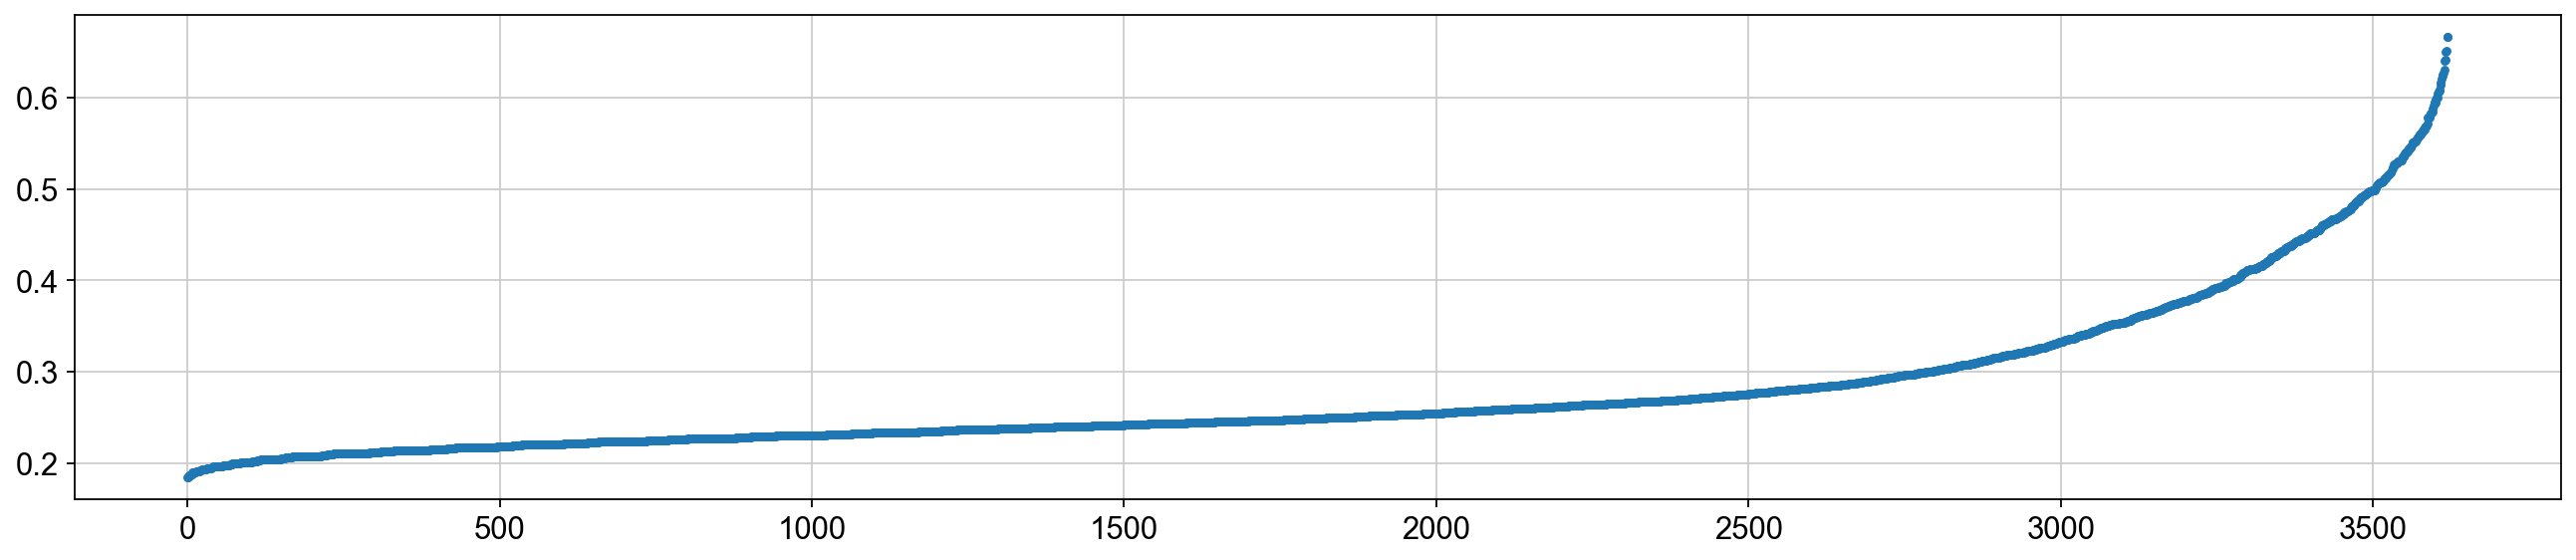

In [120]:
plt.plot(np.sort(distance_matrix_df.min(0)), '.')

In [265]:
adata = adata_cluster.copy()
adata.obs_names = [item1+'_'+item2 for item1, item2 in zip(adata.obs['target_contrast_gene_name_corrected'], adata.obs['culture_condition'])]
distance_matrix_df = 1 - norm_cooc_matrix_df
np.fill_diagonal(distance_matrix_df.values, 1)
distance_matrix_df = distance_matrix_df.loc[distance_matrix_df.min(0)<0.3, distance_matrix_df.min(1)<0.3].copy()
adata = adata[distance_matrix_df.index].copy()

In [317]:
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=3,
                            min_samples=1,
                            max_cluster_size=0,
                            cluster_selection_method='eom',)
clusterer.fit(distance_matrix_df.values)
#clusterer.fit(transformed_matrix)
final_labels = clusterer.labels_
adata.obs['hdbscan'] = final_labels
adata.obs['hdbscan'] = adata.obs['hdbscan'].astype('category')

In [352]:
num_of_cluster = np.max(adata.obs['hdbscan'].astype(int))+1
i = 57
list1 = adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
list2 = adata[adata.obs['hdbscan']==i].obs.culture_condition.values.tolist()
test = pd.DataFrame(data=adata[adata.obs['hdbscan']==i].layers['zscore'],
                    index=[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)],
                    columns=adata.var.gene_name)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)

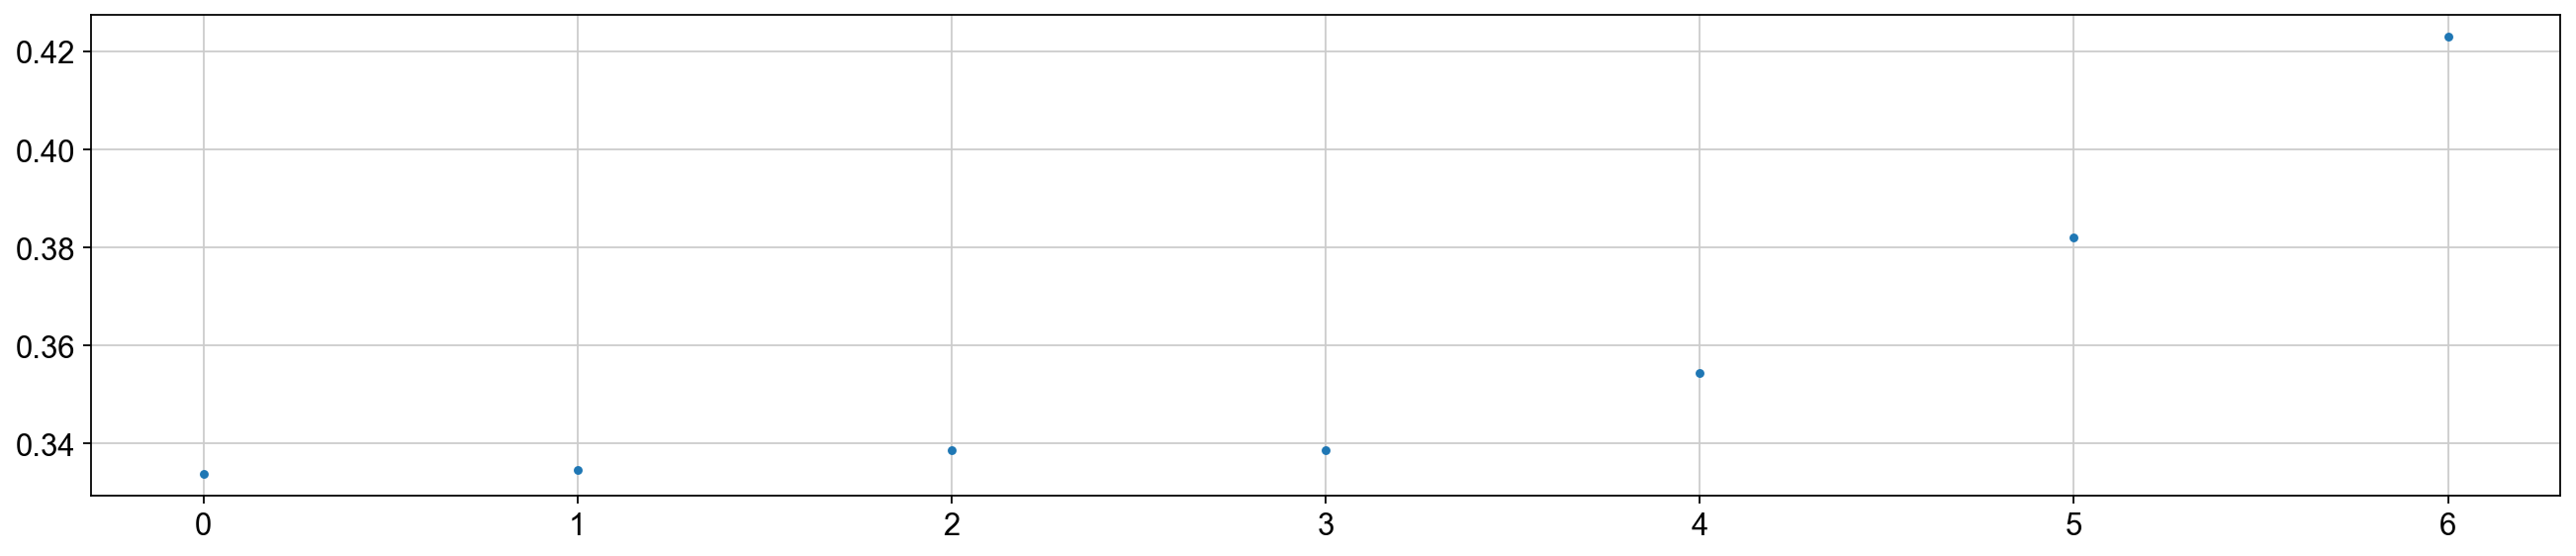

In [353]:
plt.plot(np.sort(test2.mean(0)), '.')

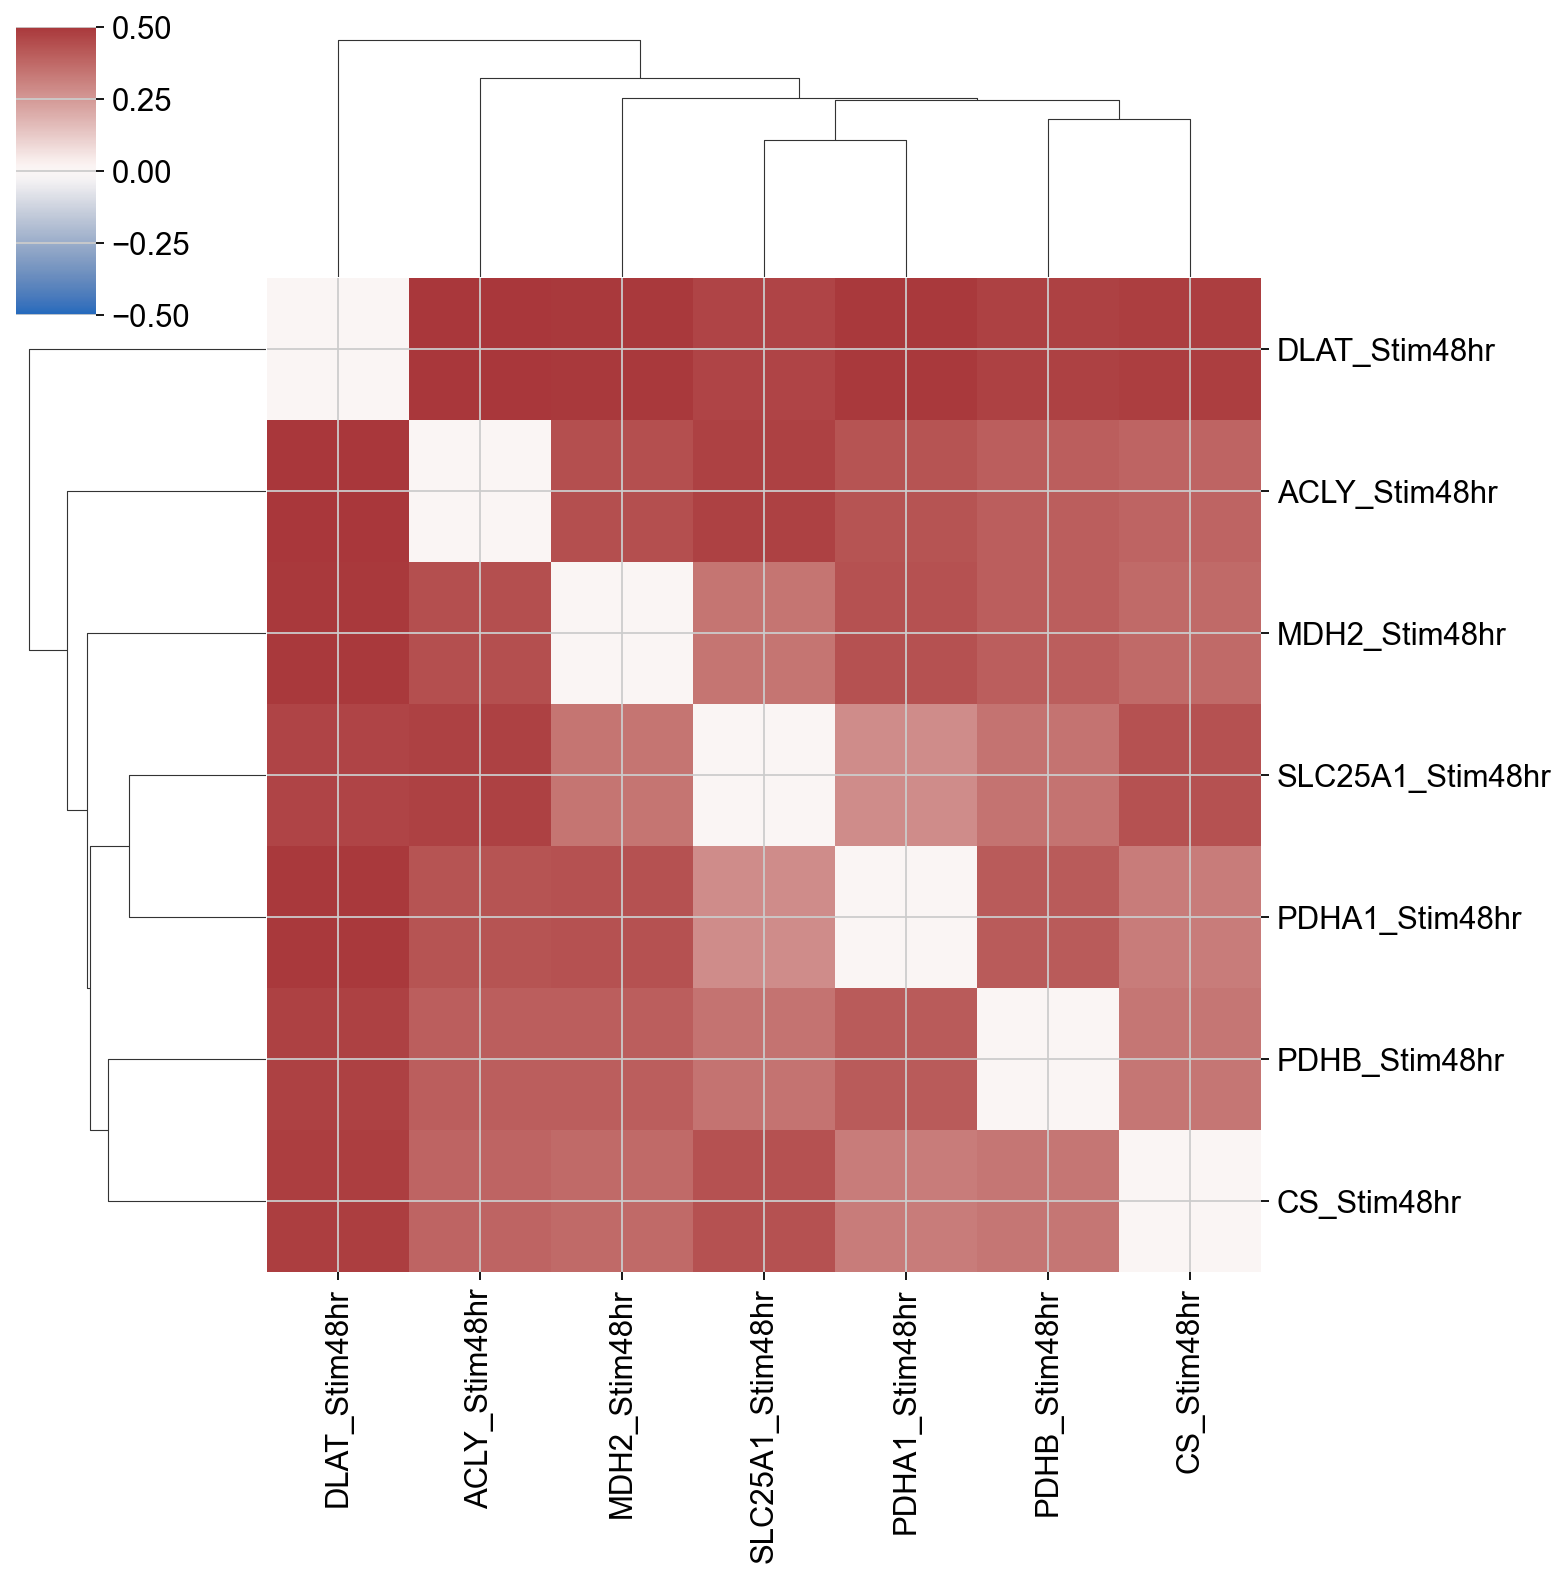

In [354]:
sns.clustermap(test2, vmin=-0.5, vmax=0.5, cmap='vlag')

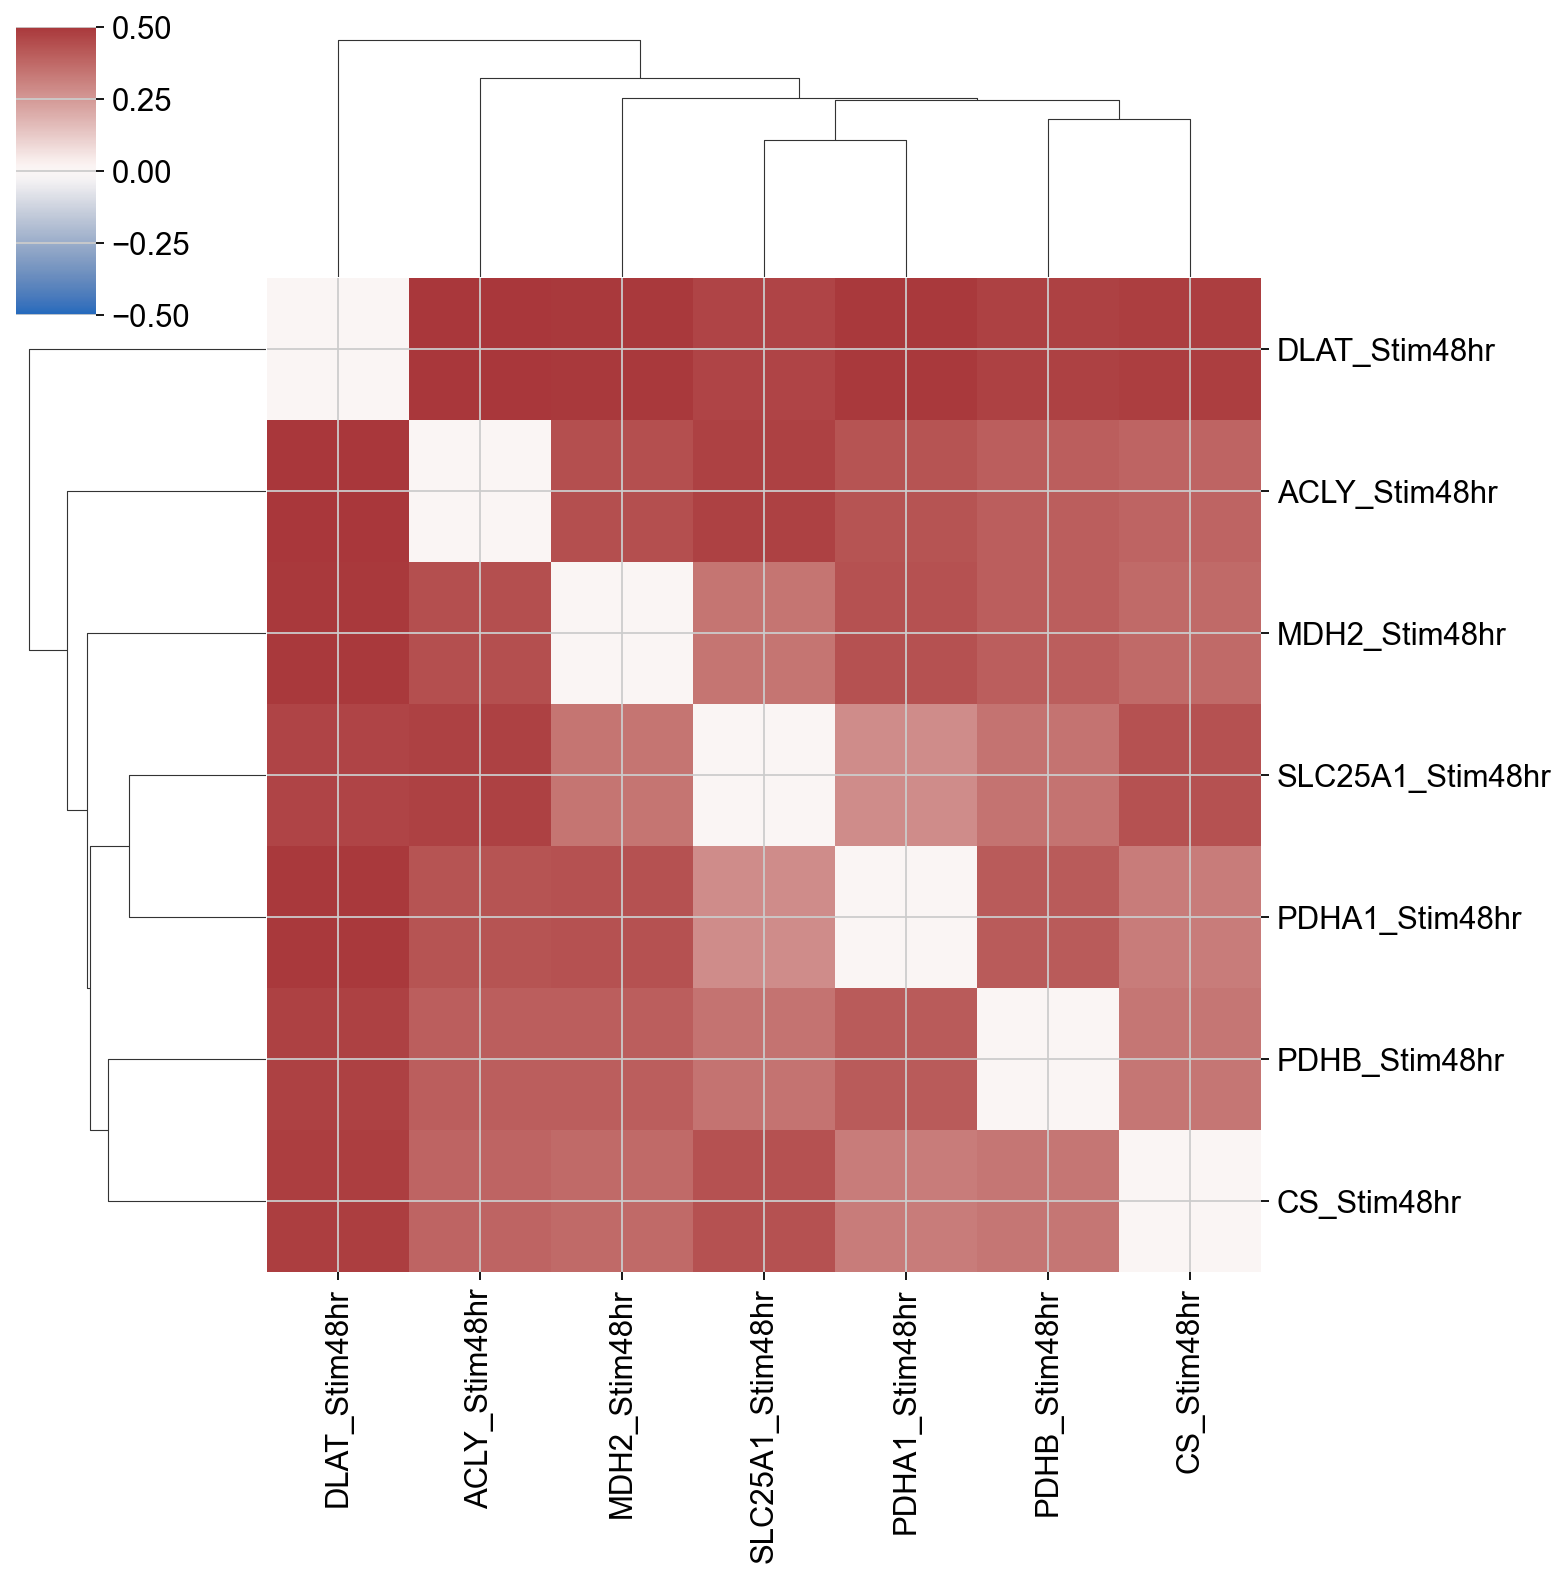

In [355]:
sns.clustermap(test2.loc[test2.mean(0)>0.2, test2.mean(0)>0.2], vmin=-0.5, vmax=0.5, cmap='vlag')

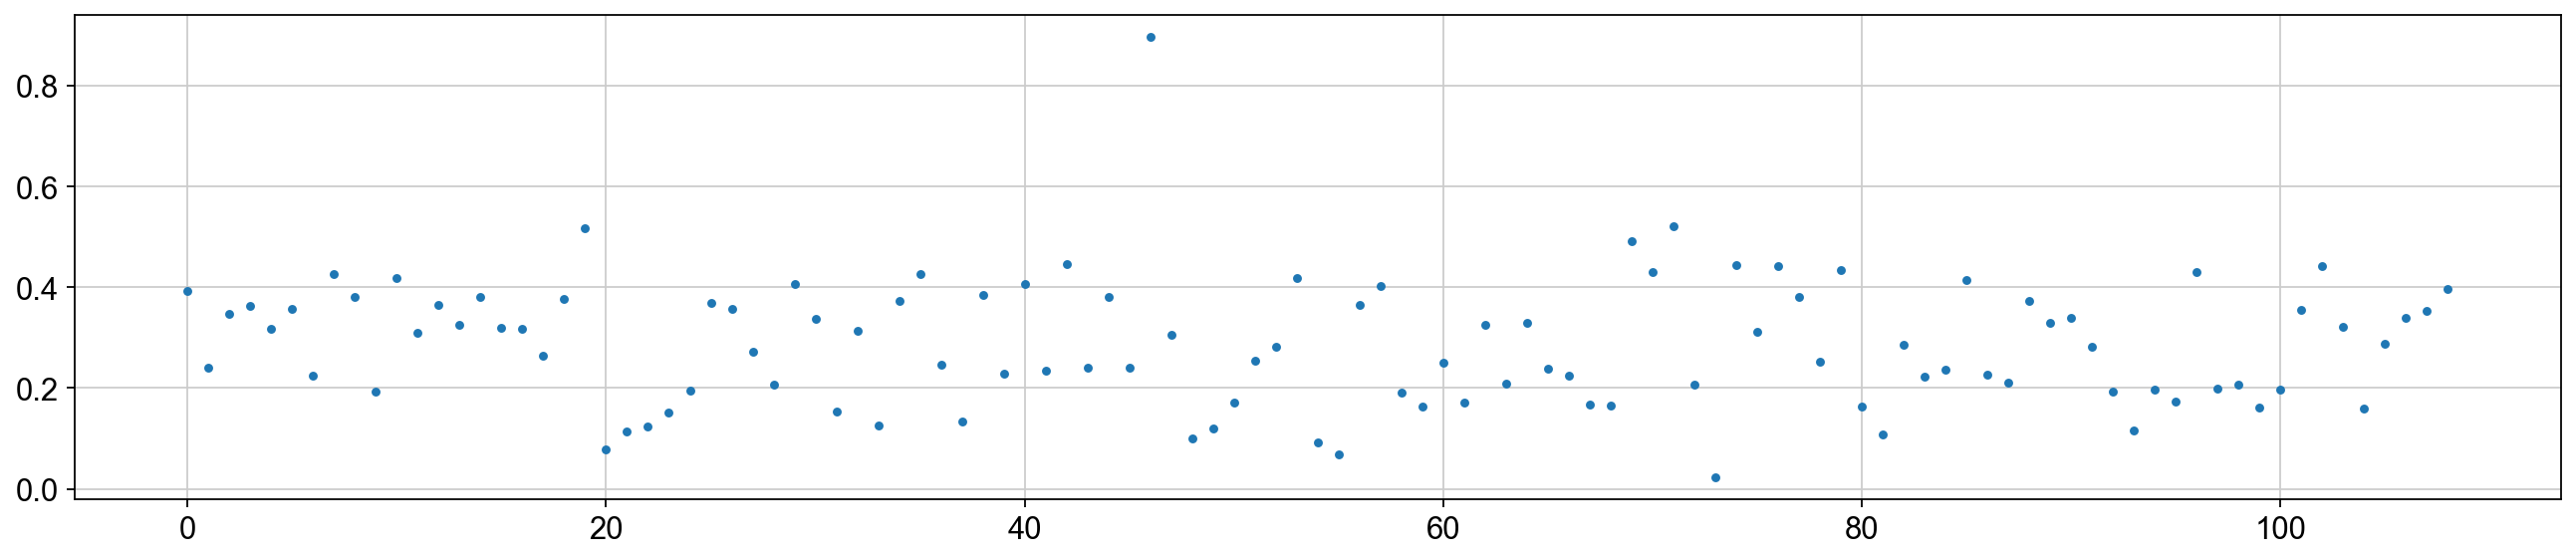

In [356]:
num_of_cluster = np.max(adata.obs['hdbscan'].astype(int))+1
corr = np.zeros(num_of_cluster)
cluster_size = np.zeros(num_of_cluster)
cluster_gene_size = np.zeros(num_of_cluster)
cluster_member = []
for i in range(len(corr)):
    list1 = adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    test = pd.DataFrame(data=adata[adata.obs['hdbscan']==i].layers['zscore'],
                        index=[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)],
                        columns=adata.var.gene_name)
    test2 = test.T.corr()
    np.fill_diagonal(test2.values, 0)
    corr[i] = np.median(test2)
    cluster_size[i] = len(test)
    cluster_gene_size[i] = len(adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique())
    cluster_member.append(adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': np.arange(0, num_of_cluster, 1),
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

plt.plot(cluster_df.intracluster_corr, '.')

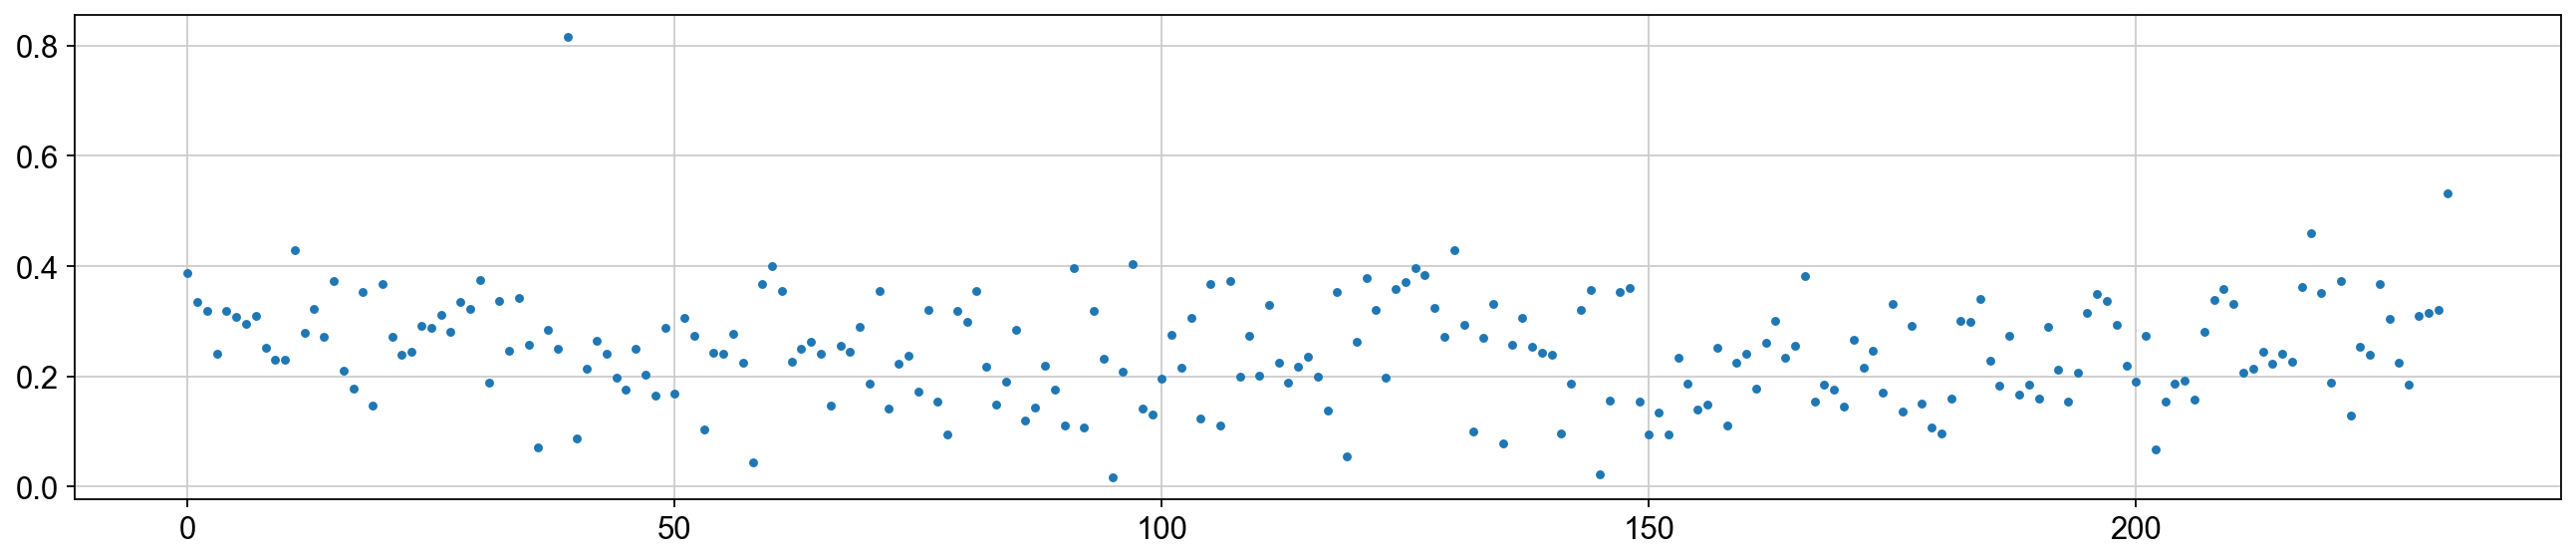

In [85]:
num_of_cluster = np.max(adata.obs['hdbscan'].astype(int))+1
corr = np.zeros(num_of_cluster)
cluster_size = np.zeros(num_of_cluster)
cluster_gene_size = np.zeros(num_of_cluster)
cluster_member = []
for i in range(len(corr)):
    list1 = adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    test = pd.DataFrame(data=adata[adata.obs['hdbscan']==i].layers['zscore'],
                        index=[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)],
                        columns=adata.var.gene_name)
    test2 = test.T.corr()
    np.fill_diagonal(test2.values, 0)
    corr[i] = np.mean(test2)
    cluster_size[i] = len(test)
    cluster_gene_size[i] = len(adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique())
    cluster_member.append(adata[adata.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': np.arange(0, num_of_cluster, 1),
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

plt.plot(cluster_df.intracluster_corr, '.')